## Notes on getting it to this stage

Most striking things to tune are:
- enforcing that the state variables are positive (reduces solve time, increases identifiability, increases parameter estimation correctness)
- increasing the regularisation value
- ensuring that the correct values in the solution are being indexed

- problems occur when the sampling domain for the data is not uniform/nice. If splines are generated that are too close to each other, and the refinement of the time grid is not large enough, then you get pathological solutions. 

## New things introduced in this notebook

- positivity constraint on the state variables

In [1]:
import modeller
import fitter

import casadi as ca
from scipy.integrate import solve_ivp
import numpy as np
from matplotlib import pyplot as plt
from importlib import reload

In [2]:
plt.rcParams['figure.figsize'] = [13, 8.]

In [3]:
p_true = [5, 0.75]
tspan = [0, 20]
def system(t, y, p):
    return [
        -p[0]*y[0]*y[1]/(y[0]+y[1]+y[2]),
        p[0]*y[0]*y[1]/(y[0]+y[1]+y[2]) - p[1]*y[1],
        p[1]*y[1]
    ]
sol = solve_ivp(lambda t, y: system(t, y, p_true), tspan, [9999, 1, 0], dense_output=True)

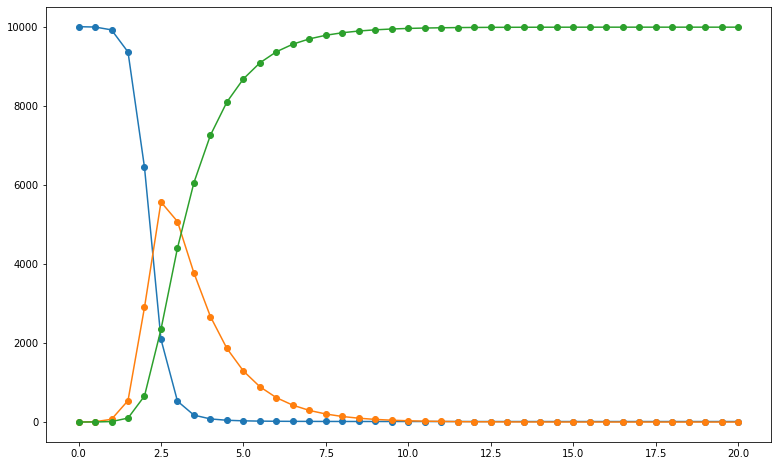

In [4]:
tofsol = np.linspace(0, 20, 41)
plt.plot(tofsol, sol.sol(tofsol).T, 'o-');

In [5]:
tofsol

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. ])

In [6]:
raw_data = sol.sol(tofsol)[2, :]
gendata = sol.sol(tofsol)[1, :]
randdata = np.abs(np.random.multivariate_normal(gendata, 10000*np.exp(-1/(2*1**2)*np.abs(gendata.reshape(1,-1)-gendata.reshape(-1,1))**2)).reshape(1,-1))
data = (np.cumsum(randdata)*p_true[1]*np.gradient(tofsol)).reshape(1, -1)
# data = raw_data.reshape(1,-1)
data_pd = np.array([i for i in data.T])

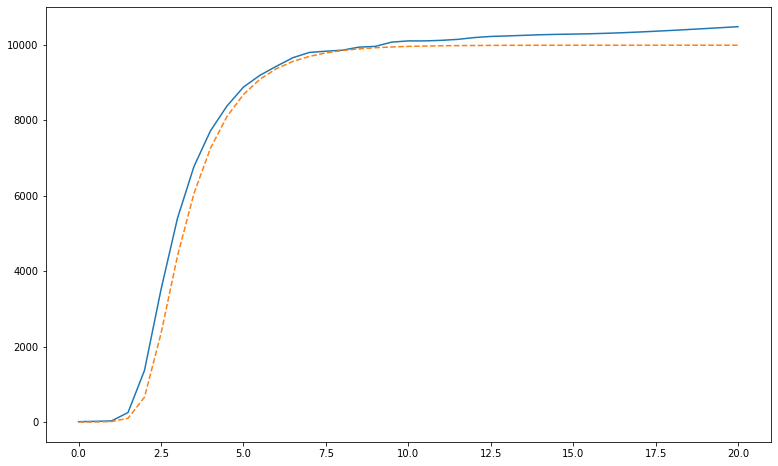

In [7]:
plt.plot(tofsol, data.T)
plt.plot(tofsol, raw_data.T, '--')

In [8]:
def knot_fn(ts, n, dataset):
    """ A curvature based knot location selection function 
    Inputs:
    ts - fine time grid
    n - number of knots
    dataset - ['y'] contains the data
              ['t'] contains the time gridding of data
    """
    y = dataset['y'].flatten()
    times = dataset['t'].flatten()
    diffs = np.gradient(np.gradient(y, times), times)
    ntimes = len(times)
    importance = sorted(range(ntimes), key=lambda i: np.abs(diffs[i]), reverse=True)
    if n <= ntimes:
        # ensure that 0 and -1 are in the knot vector
        temp_knots = importance[:n]
        if 0 in temp_knots:
            temp_knots.remove(0)
        if (ntimes-1) in temp_knots:
            temp_knots.remove(ntimes-1)
        knot_indices = [0] + sorted(temp_knots[:n-2]) + [-1]

        # match the times for knots
        corresponding_times = times[knot_indices]
        # align along fine grid (optional)
        return [min(ts, key=lambda t: np.abs(t-tk)) for tk in corresponding_times]
    else:
        # determine which time points to refine
        copies = (n//ntimes)*np.ones(ntimes)
        copies[importance[:(n%ntimes)]] += 1
        copies = [int(j) for j in copies]
            # compute the number of knot points in each gap
        kgn = [int(copies[0]-1)]
        for ci in copies[1:-1]:
            m = int(ci//2)
            kgn[-1]+=m
            kgn.append(m)
        kgn[-1]+=copies[-1]-1
        # select knots to keep, always keep end knots
        keep = [int(ci%2) for ci in copies]
        keep[-1] = 1
        knots = [times[0]]
        # construct knot locations
        for gapn, k0, k1, x0, x1, c in zip(kgn, keep[:-1], keep[1:], times[:-1], times[1:], copies[1:]):
            step = 2*(x1-x0)/(2*gapn+k0+k1)
            cands = np.arange(x0-(1-k0)*step/2, x1+(3-k1)*step/2, step)
            frag = cands[1:(gapn+1+k1)]
            knots.extend(frag)
        return sorted(knots)


In [9]:
config = {
    "grid_size": 120,
    "basis_number": 60,
    "model_form": {
        "state": 3,
        "parameters": 2
    },
    "time_span": tspan,
    "knot_function": knot_fn,
    "model": system,
    "dataset": {"y": data_pd, "t": tofsol},
    "observation_vector": [2],
    "weightings":[
        [1]*3,
        [1]*len(tofsol)
    ],
    "regularisation_value": [1]*len(p_true),
}

In [10]:
model = modeller.Model(config)
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup)

In [11]:
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getp', [solver_setup['x']], model.ps)

In [12]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])

In [13]:
p0 = np.ones(2)
# p0 = p_true
c0 = [c*np.linspace(1, 0, config['basis_number'])+d for c,d in zip([10000, 1, -10000], [0, 0, 10000])]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*3) + [0]*len(config['regularisation_value'])

In [14]:
pure_data = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    21600
Number of nonzeros in Lagrangian Hessian.............:    16653

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

[100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 99988.7, 100021, 99974.7, 100040, 99952, 100102, 100924, 99482.2, 100292, 99838.1, 100088, 99952.9, 100025, 99986.2, 100007, 99996, 100002, 99998.9, 100001, 99999.7, 100000, 99999.9, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 9.71805, 1.81109e+06, -795113, 5

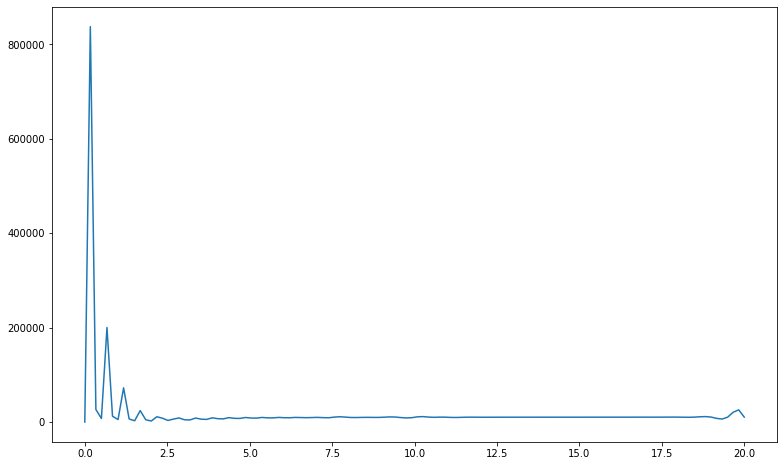

In [15]:
pure_xs = getx(pure_data['x'])
print(pure_data['x'])
plt.plot(model.observation_times, pure_xs[-1])


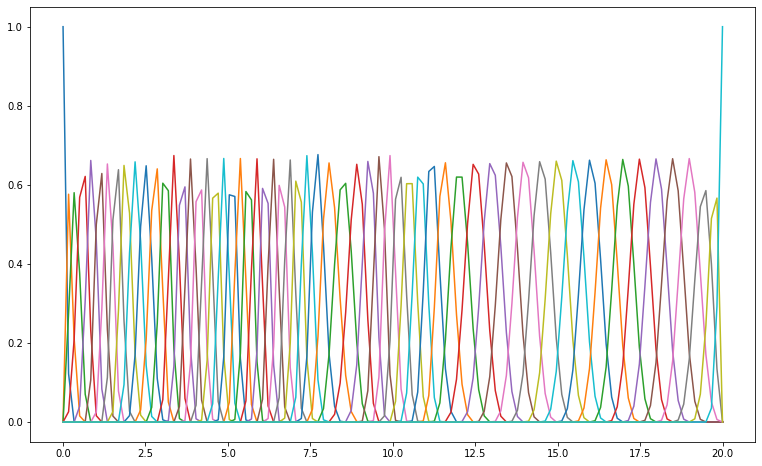

In [16]:
plt.plot(model.observation_times, model.phi);

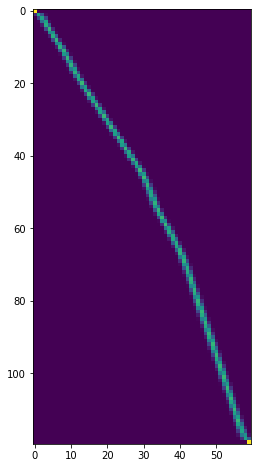

In [17]:
plt.imshow(model.phi)

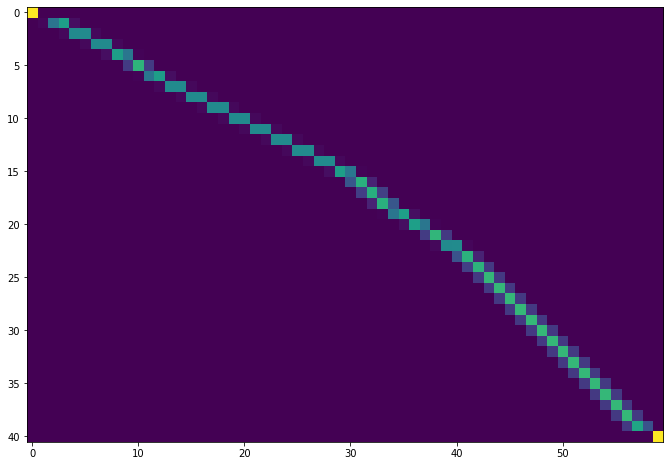

In [18]:
plt.imshow(objective.collocation_matrices[0])

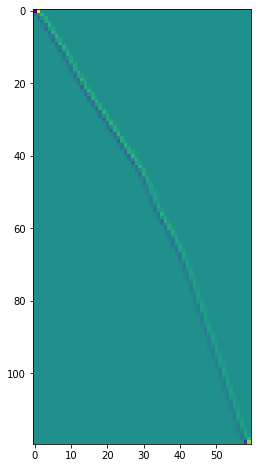

In [19]:
plt.imshow(model.basis_jacobian)

In [20]:
x0 = list(np.array(pure_data['x'][:-2]).flatten()) + list(p0)

In [21]:
prange = np.logspace(-6, 6, num=200)
solutions = []
xguess = x0
for p in prange:
    solutions.append(solver(x0=xguess, p=[p, 1], lbx=lbx, lbg=0))
    xguess = np.array(solutions[-1]['x']).flatten()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    21600
Number of nonzeros in Lagrangian Hessian.............:    16653

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  89  2.3143784e+00 0.00e+00 5.97e-03  -8.6 2.68e+03 -15.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  2.3140083e+00 0.00e+00 7.29e-03  -8.6 2.83e+03    -  1.00e+00 1.00e+00h  1
  91  2.3135929e+00 0.00e+00 5.11e-03  -8.6 2.48e+03 -15.9 1.00e+00 1.00e+00h  1
  92  2.3132485e+00 0.00e+00 9.06e-03  -8.6 4.89e+03 -16.4 1.00e+00 1.00e+00h  1
  93  2.3127056e+00 0.00e+00 3.93e-03  -8.6 1.83e+03 -16.9 1.00e+00 1.00e+00h  1
  94  2.3125005e+00 0.00e+00 1.20e-02  -8.6 7.30e+03 -16.5 1.00e+00 5.00e-01h  2
  95  2.3118337e+00 0.00e+00 2.85e-03  -8.6 1.58e+03 -17.0 1.00e+00 1.00e+00h  1
  96  2.3114034e+00 0.00e+00 1.92e-02  -8.6 9.07e+04    -  1.00e+00 2.50e-01h  3
  97  2.3113966e+00 0.00e+00 2.44e-02  -8.6 1.64e+06 -13.8 9.55e-02 2.36e-03h  3
  98  2.3098412e+00 0.00e+00 1.70e-03  -8.6 3.93e+03    -  1.00e+00 1.00e+00h  1
  99  2.3097345e+00 0.00e+00 2.06e-02  -8.6 4.16e+04    -  1.00e+00 1.01e-01h  4
iter    objective    inf_pr 

 187  2.0574864e+00 0.00e+00 7.53e-03  -8.6 1.43e+04    -  1.00e+00 2.13e-01h  3
 188  2.0559118e+00 0.00e+00 2.17e-03  -8.6 4.79e+03    -  1.00e+00 1.00e+00h  1
 189  2.0575209e+00 0.00e+00 3.34e-02  -8.6 1.37e+04    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  2.0532860e+00 0.00e+00 3.05e-04  -8.6 1.35e+03 -13.9 1.00e+00 1.00e+00h  1
 191  2.0525107e+00 0.00e+00 6.82e-03  -8.6 1.42e+04 -14.3 1.00e+00 2.50e-01h  3
 192  2.0513624e+00 0.00e+00 3.85e-03  -8.6 4.70e+03    -  1.00e+00 1.00e+00h  1
 193  2.0498188e+00 0.00e+00 3.30e-03  -8.6 3.12e+04    -  1.00e+00 1.00e+00H  1
 194  2.0487265e+00 0.00e+00 5.77e-03  -8.6 3.59e+03    -  1.00e+00 1.00e+00h  1
 195  2.0467741e+00 0.00e+00 1.33e-02  -8.6 5.76e+04 -14.8 1.00e+00 1.00e+00H  1
 196  2.0462784e+00 0.00e+00 1.83e-02  -8.6 3.98e+03 -15.3 1.00e+00 1.00e+00h  1
 197  2.0445915e+00 0.00e+00 5.82e-03  -8.6 4.83e+03    -  1.00e+00 1.00e+00h  1
 198  2.0463494e+00 0.00e+00

 281  4.5045273e-01 0.00e+00 2.74e-06  -8.6 3.33e+02    -  4.90e-03 1.09e-01f  1
 282  4.4898538e-01 0.00e+00 2.02e-06  -8.6 3.41e+02    -  4.76e-03 1.97e-01f  1
 283  4.4812636e-01 0.00e+00 1.69e-06  -8.6 3.16e+02    -  4.41e-03 1.30e-01f  1
 284  4.4735493e-01 0.00e+00 1.46e-06  -8.6 3.29e+02    -  4.21e-03 1.07e-01f  1
 285  4.4599606e-01 0.00e+00 1.02e-06  -8.6 3.37e+02    -  4.09e-03 1.93e-01f  1
 286  4.4522274e-01 0.00e+00 8.37e-07  -8.6 3.14e+02    -  3.79e-03 1.22e-01f  1
 287  4.4450655e-01 0.00e+00 7.08e-07  -8.6 3.27e+02    -  3.60e-03 1.03e-01f  1
 288  4.4324444e-01 0.00e+00 4.37e-07  -8.6 3.35e+02    -  3.44e-03 1.85e-01f  1
 289  4.4254644e-01 0.00e+00 3.43e-07  -8.6 3.14e+02    -  3.10e-03 1.13e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290  4.4186807e-01 0.00e+00 2.72e-07  -8.6 3.29e+02    -  2.83e-03 1.00e-01f  1
 291  4.4063780e-01 0.00e+00 1.21e-07  -8.6 3.36e+02    -  2.57e-03 1.85e-01f  1
 292  4.3999745e-01 0.00e+00

   5  6.2575887e-01 0.00e+00 1.28e-02  -2.5 1.89e+03    -  8.83e-01 1.00e+00f  1
   6  5.5186020e-01 0.00e+00 1.89e-02  -2.5 3.78e+03    -  9.57e-01 1.00e+00f  1
   7  4.3145258e-01 0.00e+00 2.33e-02  -3.8 2.46e+03    -  9.27e-01 1.00e+00f  1
   8  4.2049336e-01 0.00e+00 6.79e-03  -3.8 2.57e+03    -  9.62e-01 1.00e+00f  1
   9  4.1791350e-01 0.00e+00 2.23e-03  -3.8 1.93e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.1769911e-01 0.00e+00 1.17e-04  -3.8 4.88e+02    -  1.00e+00 1.00e+00f  1
  11  4.1319117e-01 0.00e+00 4.86e-02  -5.7 1.76e+04    -  9.57e-01 5.00e-01f  2
  12  4.1125142e-01 0.00e+00 3.05e-03  -5.7 1.26e+03    -  1.00e+00 1.00e+00f  1
  13  4.1113742e-01 0.00e+00 3.37e-04  -5.7 4.96e+02    -  1.00e+00 1.00e+00f  1
  14  4.1113020e-01 0.00e+00 4.78e-06  -5.7 2.05e+01    -  1.00e+00 1.00e+00h  1
  15  4.1112633e-01 0.00e+00 1.30e-05  -8.6 8.10e+01    -  1.00e+00 1.00e+00h  1
  16  4.1112631e-01 0.00e+00

  13  5.3303717e-01 0.00e+00 4.19e-03  -5.7 1.22e+03    -  1.00e+00 1.00e+00f  1
  14  5.3302632e-01 0.00e+00 1.37e-04  -5.7 2.55e+02    -  1.00e+00 1.00e+00h  1
  15  5.3302642e-01 0.00e+00 6.91e-07  -5.7 1.75e+01    -  1.00e+00 1.00e+00h  1
  16  5.3302361e-01 0.00e+00 9.98e-06  -8.6 5.37e+01    -  1.00e+00 1.00e+00h  1
  17  5.3302360e-01 0.00e+00 1.53e-08  -8.6 6.05e-01    -  1.00e+00 1.00e+00h  1
  18  5.3302360e-01 0.00e+00 1.07e-11  -9.0 4.66e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............:   5.3302359911777886e-01    5.3302359911777886e-01
Dual infeasibility......:   1.0729504028429418e-11    1.0729504028429418e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0937414003277886e-10    9.0937414003277886e-10
Overall NLP error.......:   9.0937414003277886e-10    9.0937414003277886e-10


Number of objective funct

  61  9.3821773e-01 0.00e+00 2.50e-01  -5.7 3.61e+02    -  3.63e-02 1.50e-01f  1
  62  9.2589017e-01 0.00e+00 1.81e-01  -5.7 3.90e+02    -  4.72e-02 2.79e-01f  1
  63  9.1978822e-01 0.00e+00 1.53e-01  -5.7 3.78e+02    -  4.57e-02 1.61e-01f  1
  64  9.1432120e-01 0.00e+00 1.31e-01  -5.7 3.91e+02    -  4.00e-02 1.44e-01f  1
  65  9.0729688e-01 0.00e+00 1.07e-01  -5.7 4.06e+02    -  4.54e-02 1.85e-01f  1
  66  9.0216513e-01 0.00e+00 9.18e-02  -5.7 4.03e+02    -  2.89e-02 1.42e-01f  1
  67  8.9593056e-01 0.00e+00 7.57e-02  -5.7 4.10e+02    -  2.79e-02 1.77e-01f  1
  68  8.9190644e-01 0.00e+00 6.67e-02  -5.7 4.02e+02    -  1.80e-02 1.20e-01f  1
  69  8.8741472e-01 0.00e+00 5.83e-02  -5.7 4.19e+02    -  2.28e-02 1.26e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  8.8166705e-01 0.00e+00 4.86e-02  -5.7 4.22e+02    -  2.69e-02 1.67e-01f  1
  71  8.7835303e-01 0.00e+00 4.38e-02  -5.7 4.16e+02    -  2.40e-02 9.85e-02f  1
  72  8.7251213e-01 0.00e+00

   1  6.8922554e-01 0.00e+00 1.00e-02  -1.0 2.76e-01    -  9.90e-01 1.00e+00f  1
   2  9.5348565e-01 0.00e+00 3.87e-01  -1.0 3.24e+01    -  9.15e-01 1.00e+00f  1
   3  9.7433598e-01 0.00e+00 1.11e-01  -1.0 2.84e+02    -  8.56e-01 1.00e+00f  1
   4  1.8197654e+00 0.00e+00 3.27e-01  -1.0 1.59e+03    -  9.57e-01 1.00e+00f  1
   5  1.8097001e+00 0.00e+00 5.69e-01  -1.7 5.84e+03    -  9.11e-01 1.00e+00f  1
   6  2.8820331e+00 0.00e+00 4.16e+00  -1.7 2.29e+04    -  6.89e-01 1.00e+00f  1
   7  3.0983982e+00 0.00e+00 1.40e+00  -1.7 2.44e+04    -  1.00e+00 1.00e+00f  1
   8  3.0857399e+00 0.00e+00 6.15e-05  -1.7 2.36e-01  -4.0 1.00e+00 1.00e+00f  1
   9  2.4372424e+00 0.00e+00 1.84e+00  -3.8 2.82e+04    -  1.23e-01 6.45e-02f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4536446e+00 0.00e+00 1.45e+00  -3.8 6.48e+03    -  8.48e-01 1.00e+00f  1
  11  1.1254760e+00 0.00e+00 1.32e+00  -3.8 9.91e+03    -  9.84e-01 1.00e+00f  1
  12  7.4120444e-01 0.00e+00

  32  1.3482457e+00 0.00e+00 2.61e+00  -8.6 6.56e+03  -9.4 2.08e-03 3.59e-01f  1
  33  1.1080060e+00 0.00e+00 2.61e+00  -8.6 2.25e+03    -  1.07e-01 1.00e+00f  1
  34  8.7359434e-01 0.00e+00 3.50e-01  -8.6 2.26e+03    -  5.17e-01 8.86e-01f  1
  35  8.1349950e-01 0.00e+00 3.75e-01  -8.6 3.45e+03    -  3.72e-01 5.00e-01f  2
  36  7.8671570e-01 0.00e+00 4.87e-02  -8.6 2.08e+03    -  1.00e+00 1.00e+00f  1
  37  7.8081889e-01 0.00e+00 3.34e-02  -8.6 1.88e+03    -  1.00e+00 1.00e+00f  1
  38  7.7940423e-01 0.00e+00 1.18e-02  -8.6 1.31e+03    -  1.00e+00 1.00e+00f  1
  39  7.7922390e-01 0.00e+00 2.42e-03  -8.6 6.34e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  7.7921881e-01 0.00e+00 8.39e-05  -8.6 1.23e+02    -  1.00e+00 1.00e+00h  1
  41  7.7921880e-01 0.00e+00 1.03e-07  -8.6 4.32e+00    -  1.00e+00 1.00e+00h  1
  42  7.7921880e-01 0.00e+00 1.70e-13  -8.6 5.19e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 4

   4  1.4724073e+00 0.00e+00 5.31e-02  -1.7 1.05e+03    -  9.62e-01 1.00e+00f  1
   5  1.1686186e+00 0.00e+00 9.49e-02  -2.5 2.40e+03    -  9.53e-01 1.00e+00f  1
   6  1.1974130e+00 0.00e+00 8.54e-01  -2.5 1.34e+04    -  9.53e-01 1.00e+00f  1
   7  1.1590875e+00 0.00e+00 3.10e-02  -2.5 1.16e+04    -  1.00e+00 1.00e+00f  1
   8  1.1688372e+00 0.00e+00 2.59e-01  -2.5 2.14e+04    -  1.00e+00 1.00e+00f  1
   9  1.1820886e+00 0.00e+00 1.24e-01  -2.5 2.85e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1828729e+00 0.00e+00 1.02e-03  -2.5 1.25e+03    -  1.00e+00 1.00e+00f  1
  11  1.0925219e+00 0.00e+00 1.46e-02  -3.8 1.03e+04    -  9.78e-01 1.00e+00f  1
  12  1.0699731e+00 0.00e+00 2.37e-01  -3.8 3.60e+06    -  2.65e-01 1.06e-02f  2
  13  1.0484335e+00 0.00e+00 9.72e-03  -3.8 4.32e+03    -  1.00e+00 1.00e+00f  1
  14  1.0484258e+00 0.00e+00 1.18e-06  -3.8 1.18e-02  -4.0 1.00e+00 1.00e+00h  1
  15  1.0484104e+00 0.00e+00

  34  1.1263972e+00 0.00e+00 5.72e-02  -8.6 3.21e+03    -  1.00e+00 1.00e+00f  1
  35  1.1249789e+00 0.00e+00 1.61e-01  -8.6 3.83e+03    -  1.00e+00 1.00e+00f  1
  36  1.1217122e+00 0.00e+00 3.51e-03  -8.6 5.03e+02    -  1.00e+00 1.00e+00f  1
  37  1.1216156e+00 0.00e+00 1.84e-03  -8.6 3.33e+02    -  1.00e+00 1.00e+00f  1
  38  1.1216149e+00 0.00e+00 4.86e-06  -8.6 2.02e+01    -  1.00e+00 1.00e+00h  1
  39  1.1216149e+00 0.00e+00 9.92e-10  -8.6 2.56e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 39

                                   (scaled)                 (unscaled)
Objective...............:   1.1216148815413500e+00    1.1216148815413500e+00
Dual infeasibility......:   9.9171768524237663e-10    9.9171768524237663e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   2.5059035596800622e-09    2.5059035596800622e-09


Number of objective funct

   6  4.8042198e+00 0.00e+00 1.14e+01  -1.7 1.44e+04    -  1.00e+00 1.00e+00f  1
   7  3.9038910e+00 0.00e+00 3.86e-04  -1.7 7.11e-01  -4.0 1.00e+00 1.00e+00f  1
   8  3.7078891e+00 0.00e+00 3.75e+00  -3.8 8.31e+03    -  2.70e-01 2.36e-01f  1
   9  1.6140707e+00 0.00e+00 3.91e-01  -3.8 6.51e+03    -  2.83e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5215392e+00 0.00e+00 5.72e-02  -3.8 2.93e+03    -  1.54e-01 1.00e+00f  1
  11  1.5010954e+00 0.00e+00 1.33e-02  -3.8 2.34e+03    -  4.71e-01 1.00e+00f  1
  12  1.4805835e+00 0.00e+00 5.46e-02  -3.8 4.38e+03    -  9.61e-01 1.00e+00f  1
  13  1.4547132e+00 0.00e+00 5.45e-01  -3.8 3.30e+04    -  1.00e+00 3.00e-01f  2
  14  1.4259862e+00 0.00e+00 6.23e-02  -3.8 1.04e+03    -  1.00e+00 1.00e+00f  1
  15  1.4180677e+00 0.00e+00 9.33e-02  -3.8 4.83e+03    -  1.00e+00 5.00e-01f  2
  16  1.4170748e+00 0.00e+00 1.64e-03  -3.8 1.01e+02    -  1.00e+00 1.00e+00f  1
  17  1.4169717e+00 0.00e+00

   5  2.9841450e+00 0.00e+00 2.70e+00  -1.7 1.58e+04    -  5.33e-01 5.00e-01f  2
   6  3.2631295e+00 0.00e+00 8.15e-01  -1.7 1.30e+04    -  1.00e+00 1.00e+00f  1
   7  3.3810582e+00 0.00e+00 1.18e+00  -1.7 1.58e+04    -  7.89e-01 1.00e+00f  1
   8  3.4212904e+00 0.00e+00 9.13e-01  -1.7 2.75e+04    -  1.00e+00 1.00e+00f  1
   9  3.4724523e+00 0.00e+00 1.58e-01  -1.7 2.17e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6307728e+00 0.00e+00 8.70e-01  -2.5 2.60e+03    -  5.97e-01 3.35e-01f  2
  11  2.1999443e+00 0.00e+00 1.77e-01  -2.5 5.42e+03    -  1.00e+00 1.00e+00f  1
  12  2.1048736e+00 0.00e+00 3.29e-02  -2.5 9.32e+03    -  1.00e+00 1.00e+00f  1
  13  2.0988071e+00 0.00e+00 1.36e-04  -2.5 9.82e+01    -  1.00e+00 1.00e+00f  1
  14  1.9949663e+00 0.00e+00 1.60e-01  -3.8 2.50e+04    -  9.79e-01 1.00e+00f  1
  15  1.9939763e+00 0.00e+00 9.37e-06  -3.8 8.68e-02  -4.0 1.00e+00 1.00e+00f  1
  16  1.9938352e+00 0.00e+00

   1  2.1821351e+00 0.00e+00 1.01e-02  -1.0 2.60e-01    -  9.90e-01 1.00e+00f  1
   2  2.2875842e+00 0.00e+00 1.73e-01  -1.0 2.88e+01    -  9.37e-01 1.00e+00f  1
   3  2.6263872e+00 0.00e+00 2.60e-01  -1.0 3.23e+02    -  9.79e-01 1.00e+00f  1
   4  3.1089942e+00 0.00e+00 3.77e-01  -1.7 1.89e+03    -  9.54e-01 1.00e+00f  1
   5  3.8263587e+00 0.00e+00 4.31e+00  -1.7 1.72e+04    -  5.07e-01 5.00e-01f  2
   6  3.9579272e+00 0.00e+00 2.31e+00  -1.7 1.25e+04    -  1.00e+00 1.00e+00f  1
   7  3.7463278e+00 0.00e+00 2.09e+00  -1.7 2.10e+04    -  6.41e-01 1.00e+00f  1
   8  3.7438915e+00 0.00e+00 3.85e-01  -1.7 2.80e+04    -  1.00e+00 1.00e+00f  1
   9  3.7817385e+00 0.00e+00 1.11e-01  -1.7 1.63e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.1916167e+00 0.00e+00 1.66e+00  -2.5 3.20e+03    -  7.67e-01 1.00e+00f  1
  11  2.6320850e+00 0.00e+00 3.99e-01  -2.5 1.81e+03    -  5.03e-01 1.00e+00f  1
  12  2.6263678e+00 0.00e+00

   4  3.6126941e+00 0.00e+00 4.29e-01  -1.7 1.52e+03    -  9.74e-01 1.00e+00f  1
   5  3.7596408e+00 0.00e+00 2.31e+00  -1.7 1.67e+04    -  5.20e-01 2.50e-01f  3
   6  4.3368877e+00 0.00e+00 4.32e+00  -1.7 1.23e+04    -  1.00e+00 1.00e+00f  1
   7  4.3530030e+00 0.00e+00 1.48e+00  -1.7 6.24e+03    -  1.00e+00 1.00e+00f  1
   8  4.5948818e+00 0.00e+00 3.54e+00  -1.7 1.31e+05    -  1.75e-01 2.50e-01f  3
   9  4.3835760e+00 0.00e+00 3.82e-01  -1.7 4.08e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.3257666e+00 0.00e+00 7.03e-03  -1.7 3.99e+03    -  1.00e+00 1.00e+00f  1
  11  3.5882650e+00 0.00e+00 1.30e+00  -3.8 5.54e+03    -  7.48e-01 1.00e+00f  1
  12  3.2532779e+00 0.00e+00 1.96e-01  -3.8 1.25e+04    -  5.68e-01 1.00e+00f  1
  13  3.1692766e+00 0.00e+00 5.24e-01  -3.8 6.91e+04    -  9.02e-01 5.00e-01f  2
  14  3.0865392e+00 0.00e+00 1.27e+00  -3.8 8.47e+04    -  1.00e+00 2.47e-01f  2
  15  2.9052175e+00 0.00e+00

   5  9.9841687e+00 0.00e+00 2.21e-02  -1.0 5.45e+00  -4.0 1.00e+00 1.00e+00f  1
   6  5.3534976e+00 0.00e+00 9.37e+00  -2.5 1.62e+03    -  6.92e-01 1.00e+00f  1
   7  3.8942639e+00 0.00e+00 8.29e-01  -2.5 2.18e+03    -  9.91e-01 1.00e+00f  1
   8  3.6173156e+00 0.00e+00 1.09e+00  -2.5 2.63e+03    -  9.65e-01 5.00e-01f  2
   9  3.5734010e+00 0.00e+00 2.21e-04  -2.5 1.76e+00  -4.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.5661648e+00 0.00e+00 1.31e-04  -3.8 3.94e+00  -5.0 1.00e+00 1.00e+00f  1
  11  3.5488946e+00 0.00e+00 1.07e-03  -5.7 7.12e+00  -5.4 9.79e-01 1.00e+00f  1
  12  3.5164243e+00 0.00e+00 5.23e-03  -5.7 1.59e+01  -5.9 1.00e+00 1.00e+00f  1
  13  3.4790291e+00 0.00e+00 8.96e-03  -5.7 2.38e+01  -6.4 1.00e+00 1.00e+00f  1
  14  3.4539598e+00 0.00e+00 6.35e-03  -5.7 4.51e+01  -6.9 1.00e+00 1.00e+00f  1
  15  3.4405170e+00 0.00e+00 1.40e-02  -5.7 6.62e+01  -7.3 1.00e+00 1.00e+00f  1
  16  3.4313128e+00 0.00e+00

   1  3.8048921e+00 0.00e+00 1.01e-02  -1.0 2.72e-01    -  9.90e-01 1.00e+00f  1
   2  3.8569783e+00 0.00e+00 7.62e-02  -1.0 2.51e+01    -  9.76e-01 1.00e+00f  1
   3  6.2632228e+00 0.00e+00 3.25e+00  -1.0 7.81e+02    -  9.62e-01 1.00e+00f  1
   4  9.3264945e+00 0.00e+00 1.26e+01  -1.0 8.16e+03    -  6.87e-01 5.00e-01f  2
   5  1.3435423e+01 0.00e+00 3.14e+01  -1.0 6.57e+03    -  7.43e-01 5.00e-01f  2
   6  1.7136767e+01 0.00e+00 2.59e+01  -1.0 3.43e+04    -  2.21e-01 2.35e-01f  2
   7  3.1379626e+01 0.00e+00 1.02e+02  -1.0 2.19e+04    -  1.00e+00 1.00e+00f  1
   8  2.2342154e+01 0.00e+00 1.70e-02  -1.0 5.89e+00  -4.0 1.00e+00 1.00e+00f  1
   9  2.2286006e+01 0.00e+00 3.81e-03  -2.5 1.70e+01  -4.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.2214529e+01 0.00e+00 9.67e-04  -3.8 2.08e+01  -5.0 1.00e+00 1.00e+00f  1
  11  2.2104040e+01 0.00e+00 2.77e-03  -3.8 4.21e+01  -5.4 1.00e+00 1.00e+00f  1
  12  2.1873769e+01 0.00e+00

   5  1.6059369e+01 0.00e+00 9.43e+00  -1.0 4.82e+04    -  1.54e-01 7.55e-02f  3
   6  1.4370835e+01 0.00e+00 7.84e+00  -1.0 5.97e+03    -  1.00e+00 1.00e+00f  1
   7  2.0788937e+01 0.00e+00 2.75e+01  -1.0 1.01e+04    -  9.24e-01 1.00e+00f  1
   8  2.1314698e+01 0.00e+00 1.22e+01  -1.0 1.58e+04    -  1.00e+00 1.00e+00f  1
   9  2.1037139e+01 0.00e+00 7.61e-04  -1.0 1.85e+00  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.0997687e+01 0.00e+00 3.84e-03  -2.5 1.47e+01  -4.5 1.00e+00 1.00e+00f  1
  11  2.0945325e+01 0.00e+00 1.10e-03  -3.8 1.80e+01  -5.0 1.00e+00 1.00e+00f  1
  12  2.0862928e+01 0.00e+00 1.08e-03  -3.8 2.09e+01  -5.4 1.00e+00 1.00e+00f  1
  13  2.0671369e+01 0.00e+00 7.90e-03  -5.7 4.33e+01  -5.9 9.62e-01 1.00e+00f  1
  14  2.0193596e+01 0.00e+00 4.15e-02  -5.7 1.19e+02  -6.4 1.00e+00 1.00e+00f  1
  15  1.9133139e+01 0.00e+00 3.46e-01  -5.7 2.79e+02  -6.9 1.00e+00 1.00e+00f  1
  16  1.6413223e+01 0.00e+00

   4  1.9150748e+01 0.00e+00 1.79e+01  -1.0 9.49e+03    -  3.65e-01 5.00e-01f  2
   5  1.6541835e+01 0.00e+00 1.42e+01  -1.0 1.10e+04    -  9.96e-01 5.00e-01f  2
   6  1.5787877e+01 0.00e+00 6.00e-03  -1.0 3.73e+00  -4.0 1.00e+00 1.00e+00f  1
   7  1.0762920e+01 0.00e+00 1.41e+01  -2.5 3.43e+03    -  5.56e-01 6.31e-01f  1
   8  6.0305945e+00 0.00e+00 2.17e+00  -2.5 2.80e+03    -  4.71e-01 1.00e+00f  1
   9  5.7275312e+00 0.00e+00 7.28e-01  -2.5 1.90e+03    -  8.26e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.5071847e+00 0.00e+00 1.52e+00  -2.5 2.05e+03    -  1.00e+00 1.00e+00f  1
  11  5.3959363e+00 0.00e+00 4.36e-01  -2.5 3.94e+02    -  1.00e+00 1.00e+00f  1
  12  5.3034355e+00 0.00e+00 7.18e-01  -2.5 1.03e+03    -  1.00e+00 1.00e+00f  1
  13  5.3005758e+00 0.00e+00 2.27e-02  -2.5 1.15e+02    -  1.00e+00 1.00e+00f  1
  14  5.2119360e+00 0.00e+00 5.27e-01  -3.8 7.84e+02    -  9.74e-01 1.00e+00f  1
  15  5.1896521e+00 0.00e+00

   3  1.6772199e+01 0.00e+00 1.82e+01  -1.0 1.11e+03    -  9.79e-01 1.00e+00f  1
   4  1.9274477e+01 0.00e+00 1.60e+01  -1.0 7.13e+03    -  4.05e-01 5.00e-01f  2
   5  1.8045624e+01 0.00e+00 2.02e+01  -1.0 5.07e+03    -  1.00e+00 1.00e+00f  1
   6  1.6067267e+01 0.00e+00 1.62e-02  -1.0 3.23e+00  -4.0 1.00e+00 1.00e+00f  1
   7  1.1059433e+01 0.00e+00 9.61e+00  -2.5 3.17e+03    -  5.99e-01 3.92e-01f  2
   8  9.9473787e+00 0.00e+00 6.12e+00  -2.5 7.73e+04    -  4.31e-01 4.98e-02f  2
   9  7.0283932e+00 0.00e+00 1.67e+00  -2.5 2.08e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.5649216e+00 0.00e+00 2.49e+00  -2.5 3.24e+03    -  1.00e+00 5.00e-01f  2
  11  6.2136692e+00 0.00e+00 4.07e-01  -2.5 5.49e+02    -  1.00e+00 1.00e+00f  1
  12  6.0986084e+00 0.00e+00 9.22e-01  -2.5 9.47e+02    -  1.00e+00 1.00e+00f  1
  13  6.0831852e+00 0.00e+00 2.34e-02  -2.5 7.58e+01    -  1.00e+00 1.00e+00f  1
  14  5.9933108e+00 0.00e+00

   9  7.5392454e+00 0.00e+00 1.17e+00  -2.5 5.71e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.2909044e+00 0.00e+00 3.19e+00  -2.5 4.15e+03    -  1.00e+00 3.77e-01f  2
  11  6.9670057e+00 0.00e+00 5.00e-02  -2.5 1.10e+02    -  1.00e+00 1.00e+00f  1
  12  6.9152143e+00 0.00e+00 4.51e-01  -2.5 5.00e+02    -  1.00e+00 1.00e+00f  1
  13  6.9196512e+00 0.00e+00 5.36e-03  -2.5 6.17e+01    -  1.00e+00 1.00e+00f  1
  14  6.8340356e+00 0.00e+00 1.97e-01  -3.8 3.15e+02    -  1.00e+00 1.00e+00f  1
  15  6.8228906e+00 0.00e+00 1.52e-03  -3.8 7.29e+01    -  1.00e+00 1.00e+00f  1
  16  6.8219410e+00 0.00e+00 3.61e-04  -3.8 1.25e+01    -  1.00e+00 1.00e+00f  1
  17  6.8210064e+00 0.00e+00 1.40e-03  -5.7 3.13e+01    -  1.00e+00 1.00e+00f  1
  18  6.8209912e+00 0.00e+00 1.97e-05  -5.7 1.38e+00    -  1.00e+00 1.00e+00f  1
  19  6.8209911e+00 0.00e+00 3.00e-08  -5.7 3.51e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

   4  1.9239155e+01 0.00e+00 1.11e+01  -1.0 3.30e+03    -  6.53e-01 5.00e-01f  2
   5  1.6252132e+01 0.00e+00 4.53e+00  -1.0 1.31e+03    -  1.00e+00 1.00e+00f  1
   6  1.5512812e+01 0.00e+00 5.94e+00  -1.0 2.49e+04    -  1.44e-01 7.94e-02f  3
   7  1.8999436e+01 0.00e+00 1.95e+01  -1.0 6.21e+03    -  1.00e+00 1.00e+00f  1
   8  1.8022342e+01 0.00e+00 4.13e+00  -1.0 4.02e+03    -  1.00e+00 1.00e+00f  1
   9  1.8437692e+01 0.00e+00 7.15e+00  -1.0 7.20e+04    -  1.70e-01 1.37e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.0521696e+01 0.00e+00 1.53e+01  -1.0 4.50e+04    -  1.00e+00 5.00e-01f  2
  11  1.9634631e+01 0.00e+00 1.43e+00  -1.0 1.15e+04    -  1.00e+00 1.00e+00f  1
  12  1.9742359e+01 0.00e+00 3.41e+00  -1.0 3.19e+04    -  1.00e+00 1.00e+00f  1
  13  1.9857924e+01 0.00e+00 7.98e-02  -1.0 3.63e+03    -  1.00e+00 1.00e+00f  1
  14  1.6951792e+01 0.00e+00 7.37e+00  -2.5 6.71e+03    -  7.51e-01 1.00e+00f  1
  15  1.4268602e+01 0.00e+00

  37  9.4347483e+00 0.00e+00 4.17e+00  -5.7 6.27e+03    -  1.00e+00 3.11e-01f  2
  38  8.7368286e+00 0.00e+00 2.58e+00  -5.7 3.70e+02    -  1.00e+00 1.00e+00f  1
  39  8.5243391e+00 0.00e+00 1.96e+00  -5.7 1.93e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  8.2943039e+00 0.00e+00 1.32e+00  -5.7 2.59e+02    -  1.00e+00 1.00e+00f  1
  41  8.2373677e+00 0.00e+00 1.36e+00  -5.7 5.58e+02    -  1.00e+00 1.00e+00f  1
  42  8.1968448e+00 0.00e+00 8.53e-02  -5.7 8.39e+01    -  1.00e+00 1.00e+00f  1
  43  8.1957224e+00 0.00e+00 4.34e-02  -5.7 6.21e+01    -  1.00e+00 1.00e+00f  1
  44  8.1957113e+00 0.00e+00 1.04e-05  -5.7 1.12e+00    -  1.00e+00 1.00e+00f  1
  45  8.1957111e+00 0.00e+00 2.03e-07  -8.6 3.49e-01    -  1.00e+00 1.00e+00h  1
  46  8.1957111e+00 0.00e+00 7.14e-13  -8.6 2.50e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 46

                                   (scaled)                 (unscaled)
Objecti

   6  1.6920164e+01 0.00e+00 4.22e-03  -1.0 2.89e+00  -4.0 1.00e+00 1.00e+00f  1
   7  1.6328099e+01 0.00e+00 2.94e-02  -2.5 1.25e+01  -4.5 9.73e-01 1.00e+00f  1
   8  1.5119322e+01 0.00e+00 1.85e-01  -2.5 3.08e+01  -5.0 1.00e+00 1.00e+00f  1
   9  1.3603009e+01 0.00e+00 3.85e-01  -2.5 4.96e+01  -5.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2493871e+01 0.00e+00 4.33e-01  -2.5 1.22e+02  -5.9 1.00e+00 1.00e+00f  1
  11  1.1631448e+01 0.00e+00 2.15e+00  -2.5 2.11e+02  -6.4 1.00e+00 1.00e+00f  1
  12  1.1108862e+01 0.00e+00 1.88e+00  -2.5 2.45e+02  -6.9 1.00e+00 1.00e+00f  1
  13  1.0877888e+01 0.00e+00 4.07e-01  -2.5 2.30e+02  -7.3 1.00e+00 1.00e+00f  1
  14  1.0640838e+01 0.00e+00 1.76e-01  -2.5 3.12e+02  -7.8 1.00e+00 1.00e+00f  1
  15  1.0085561e+01 0.00e+00 3.03e+00  -2.5 1.18e+03  -8.3 1.00e+00 1.00e+00f  1
  16  9.6261517e+00 0.00e+00 1.12e+00  -2.5 6.04e+02    -  1.00e+00 1.00e+00f  1
  17  9.4102749e+00 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0258968e+01 0.00e+00 1.73e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.0256510e+01 0.00e+00 1.03e-02  -1.0 4.34e-01    -  9.90e-01 1.00e+00f  1
   2  1.0308866e+01 0.00e+00 3.21e-02  -1.0 3.19e+01    -  9.88e-01 1.00e+00f  1
   3  2.3925091e+01 0.00e+00 2.22e+01  -1.0 7.95e+02    -  1.00e+00 1.00e+00f  1
   4  2.0657291e+01 0.00e+00 1.17e+01  -1.0 1.27e+03    -  1.00e+00 1.00e+00f  1
   5  1.7877670e+01 0.00e+00 1.07e+00  -1.0 5.60e+02    -  1.00e+00 1.00e+00f  1
   6  1.7856526e+01 0.00e+00 5.82e-04  -1.0 1.02e+00  -4.0 1.00e+00 1.00e+00f  1
   7  1.7169273e+01 0.00e+00 4.67e-02  -2.5 1.35e+01  -4.5 9.72e-01 1.00e+00f  1
   8  1.5846605e+01 0.00e+00 2.68e-01  -2.5 3.19e+01  -5.0 1.00e+00 1.00e+00f  1
   9  1.4392950e+01 0.00e+00 4.53e-01  -2.5 4.62e+01  -5.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3426087e+01 0.00e+00

   4  2.0723268e+01 0.00e+00 7.80e+00  -1.0 8.47e+02    -  1.00e+00 1.00e+00f  1
   5  1.8869441e+01 0.00e+00 7.28e-01  -1.0 2.77e+02    -  1.00e+00 1.00e+00f  1
   6  1.8594439e+01 0.00e+00 8.14e-03  -1.7 5.00e+00  -4.0 1.00e+00 1.00e+00f  1
   7  1.7816417e+01 0.00e+00 8.18e-02  -3.8 1.54e+01  -4.5 9.53e-01 1.00e+00f  1
   8  1.6478189e+01 0.00e+00 3.71e-01  -3.8 3.28e+01  -5.0 1.00e+00 1.00e+00f  1
   9  1.5219073e+01 0.00e+00 5.20e-01  -3.8 4.28e+01  -5.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4431022e+01 0.00e+00 4.98e-01  -3.8 9.60e+01  -5.9 1.00e+00 1.00e+00f  1
  11  1.3708007e+01 0.00e+00 1.93e+00  -3.8 1.56e+02  -6.4 1.00e+00 1.00e+00f  1
  12  1.3073714e+01 0.00e+00 1.73e+00  -3.8 1.80e+02  -6.9 1.00e+00 1.00e+00f  1
  13  1.2479996e+01 0.00e+00 3.34e-01  -3.8 3.47e+02  -7.3 1.00e+00 1.00e+00f  1
  14  1.2212505e+01 0.00e+00 8.91e+00  -3.8 9.38e+02  -7.8 1.00e+00 1.00e+00f  1
  15  1.1439352e+01 0.00e+00

   5  1.9877061e+01 0.00e+00 4.57e-01  -1.0 1.65e+02    -  1.00e+00 1.00e+00f  1
   6  1.7549928e+01 0.00e+00 7.90e+00  -1.7 1.94e+03    -  8.82e-01 4.13e-01f  2
   7  1.3738337e+01 0.00e+00 4.53e+00  -1.7 3.11e+02    -  1.00e+00 1.00e+00f  1
   8  1.3608181e+01 0.00e+00 1.20e-01  -1.7 1.35e+02    -  1.00e+00 1.00e+00f  1
   9  1.2772900e+01 0.00e+00 1.14e+00  -2.5 2.89e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2613639e+01 0.00e+00 1.26e-02  -2.5 1.09e+02    -  1.00e+00 1.00e+00f  1
  11  1.2520651e+01 0.00e+00 8.13e-02  -3.8 1.30e+02    -  1.00e+00 1.00e+00f  1
  12  1.2510120e+01 0.00e+00 8.84e-03  -3.8 4.92e+01    -  1.00e+00 1.00e+00f  1
  13  1.2509347e+01 0.00e+00 5.21e-04  -3.8 9.43e+00    -  1.00e+00 1.00e+00f  1
  14  1.2508685e+01 0.00e+00 6.22e-04  -5.7 1.62e+01    -  1.00e+00 1.00e+00f  1
  15  1.2508681e+01 0.00e+00 6.62e-06  -5.7 1.30e+00    -  1.00e+00 1.00e+00h  1
  16  1.2508681e+01 0.00e+00

  14  1.3754205e+01 0.00e+00 6.13e-04  -5.7 1.53e+01    -  1.00e+00 1.00e+00f  1
  15  1.3754200e+01 0.00e+00 8.75e-06  -5.7 1.42e+00    -  1.00e+00 1.00e+00h  1
  16  1.3754199e+01 0.00e+00 1.44e-07  -8.6 2.22e-01    -  1.00e+00 1.00e+00h  1
  17  1.3754199e+01 0.00e+00 5.32e-13  -8.6 3.07e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   1.3754199439539171e+01    1.3754199439539171e+01
Dual infeasibility......:   5.3199696613768751e-13    5.3199696613768751e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059109619631496e-09    2.5059109619631496e-09
Overall NLP error.......:   2.5059109619631496e-09    2.5059109619631496e-09


Number of objective function evaluations             = 18
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations            = 0
Number of ineq

   4  2.3245094e+01 0.00e+00 1.42e+00  -1.0 2.63e+02    -  1.00e+00 1.00e+00f  1
   5  2.2667341e+01 0.00e+00 2.25e-01  -1.0 5.47e+01    -  1.00e+00 1.00e+00f  1
   6  1.7896450e+01 0.00e+00 1.07e+01  -1.7 3.64e+02    -  1.00e+00 1.00e+00f  1
   7  1.6927853e+01 0.00e+00 3.30e-02  -1.7 1.39e+02    -  1.00e+00 1.00e+00f  1
   8  1.6047316e+01 0.00e+00 9.40e-01  -2.5 2.05e+02    -  1.00e+00 1.00e+00f  1
   9  1.5885061e+01 0.00e+00 3.69e-02  -2.5 8.56e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5864241e+01 0.00e+00 1.95e-03  -2.5 1.68e+01    -  1.00e+00 1.00e+00f  1
  11  1.5792555e+01 0.00e+00 2.85e-02  -3.8 8.14e+01    -  1.00e+00 1.00e+00f  1
  12  1.5784582e+01 0.00e+00 4.97e-03  -3.8 3.13e+01    -  1.00e+00 1.00e+00f  1
  13  1.5783955e+01 0.00e+00 1.61e-04  -3.8 5.90e+00    -  1.00e+00 1.00e+00f  1
  14  1.5783279e+01 0.00e+00 3.16e-04  -5.7 1.21e+01    -  1.00e+00 1.00e+00f  1
  15  1.5783273e+01 0.00e+00

  14  1.7274136e+01 0.00e+00 7.68e-08  -8.6 1.69e-01    -  1.00e+00 1.00e+00h  1
  15  1.7274136e+01 0.00e+00 6.32e-13  -8.6 2.83e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   1.7274136188229846e+01    1.7274136188229846e+01
Dual infeasibility......:   6.3244055305330822e-13    6.3244055305330822e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059172211570594e-09    2.5059172211570594e-09
Overall NLP error.......:   2.5059172211570594e-09    2.5059172211570594e-09


Number of objective function evaluations             = 16
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 16
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 16
Num

   4  2.6739449e+01 0.00e+00 1.24e+00  -1.0 1.40e+02    -  1.00e+00 1.00e+00f  1
   5  2.6252109e+01 0.00e+00 1.41e-01  -1.0 3.10e+01    -  1.00e+00 1.00e+00f  1
   6  2.1180087e+01 0.00e+00 8.42e+00  -2.5 3.06e+02    -  9.81e-01 1.00e+00f  1
   7  2.0118628e+01 0.00e+00 1.49e-01  -2.5 1.76e+02    -  1.00e+00 1.00e+00f  1
   8  1.9920087e+01 0.00e+00 2.78e-02  -2.5 7.28e+01    -  1.00e+00 1.00e+00f  1
   9  1.9830978e+01 0.00e+00 2.43e-02  -3.8 6.62e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.9820149e+01 0.00e+00 3.94e-03  -3.8 2.66e+01    -  1.00e+00 1.00e+00f  1
  11  1.9819167e+01 0.00e+00 1.67e-04  -3.8 5.98e+00    -  1.00e+00 1.00e+00f  1
  12  1.9818507e+01 0.00e+00 1.32e-04  -5.7 8.54e+00    -  1.00e+00 1.00e+00f  1
  13  1.9818501e+01 0.00e+00 3.25e-06  -5.7 8.63e-01    -  1.00e+00 1.00e+00h  1
  14  1.9818501e+01 0.00e+00 4.58e-08  -8.6 1.34e-01    -  1.00e+00 1.00e+00h  1
  15  1.9818501e+01 0.00e+00

  15  2.1821097e+01 0.00e+00 4.26e-13  -8.6 1.64e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   2.1821096885087151e+01    2.1821096885087151e+01
Dual infeasibility......:   4.2615115032635023e-13    4.2615115032635023e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059129720499441e-09    2.5059129720499441e-09
Overall NLP error.......:   2.5059129720499441e-09    2.5059129720499441e-09


Number of objective function evaluations             = 16
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 16
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 16
Number of Lagrangian Hessian evaluations             = 15
Total CPU secs in IPOPT (w

   5  2.7568748e+01 0.00e+00 4.27e+00  -1.7 2.11e+02    -  1.00e+00 1.00e+00f  1
   6  2.6545958e+01 0.00e+00 7.57e-02  -1.7 8.63e+01    -  1.00e+00 1.00e+00f  1
   7  2.5771301e+01 0.00e+00 4.60e-01  -2.5 1.04e+02    -  1.00e+00 1.00e+00f  1
   8  2.5638339e+01 0.00e+00 1.16e-02  -2.5 4.20e+01    -  1.00e+00 1.00e+00f  1
   9  2.5567571e+01 0.00e+00 1.41e-02  -3.8 4.38e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.5559656e+01 0.00e+00 1.98e-03  -3.8 1.64e+01    -  1.00e+00 1.00e+00f  1
  11  2.5559035e+01 0.00e+00 5.54e-05  -3.8 3.14e+00    -  1.00e+00 1.00e+00f  1
  12  2.5558536e+01 0.00e+00 6.02e-05  -5.7 5.33e+00    -  1.00e+00 1.00e+00f  1
  13  2.5558533e+01 0.00e+00 9.83e-07  -5.7 4.26e-01    -  1.00e+00 1.00e+00h  1
  14  2.5558532e+01 0.00e+00 1.80e-08  -8.6 7.86e-02    -  1.00e+00 1.00e+00h  1
  15  2.5558532e+01 0.00e+00 3.22e-12  -9.0 1.60e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 1

  15  2.8774984e+01 0.00e+00 3.26e-13  -9.0 1.14e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   2.8774983817321626e+01    2.8774983817321626e+01
Dual infeasibility......:   3.2630260761837728e-13    3.2630260761837728e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909933862065105e-10    9.0909933862065105e-10
Overall NLP error.......:   9.0909933862065105e-10    9.0909933862065105e-10


Number of objective function evaluations             = 16
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 16
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 16
Number of Lagrangian Hessian evaluations             = 15
Total CPU secs in IPOPT (w

   1  3.5278912e+01 0.00e+00 1.03e-02  -1.0 4.63e-01    -  9.90e-01 1.00e+00f  1
   2  3.5609505e+01 0.00e+00 4.76e-01  -1.0 1.94e+01    -  9.89e-01 1.00e+00f  1
   3  5.3987529e+01 0.00e+00 2.10e-01  -1.0 6.62e+02    -  1.00e+00 1.00e+00f  1
   4  3.9848870e+01 0.00e+00 3.46e+00  -1.7 3.22e+02    -  1.00e+00 1.00e+00f  1
   5  3.6672638e+01 0.00e+00 3.95e-01  -1.7 1.56e+02    -  1.00e+00 1.00e+00f  1
   6  3.6071909e+01 0.00e+00 3.99e-02  -1.7 5.08e+01    -  1.00e+00 1.00e+00f  1
   7  3.5429230e+01 0.00e+00 2.73e-01  -2.5 7.23e+01    -  1.00e+00 1.00e+00f  1
   8  3.5324932e+01 0.00e+00 9.44e-03  -2.5 2.76e+01    -  1.00e+00 1.00e+00f  1
   9  3.5268692e+01 0.00e+00 5.57e-03  -3.8 2.94e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.5263448e+01 0.00e+00 1.07e-03  -3.8 9.80e+00    -  1.00e+00 1.00e+00f  1
  11  3.5262831e+01 0.00e+00 1.08e-04  -5.7 4.32e+00    -  1.00e+00 1.00e+00f  1
  12  3.5262827e+01 0.00e+00

  12  4.1165761e+01 0.00e+00 3.70e-07  -5.7 1.96e-01    -  1.00e+00 1.00e+00h  1
  13  4.1165761e+01 0.00e+00 6.25e-09  -8.6 3.32e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   4.1165760820572530e+01    4.1165760820572530e+01
Dual infeasibility......:   6.2473309640518151e-09    6.2473309640518151e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.8186002892765051e-09    3.8186002892765051e-09
Overall NLP error.......:   6.2473309640518151e-09    6.2473309640518151e-09


Number of objective function evaluations             = 14
Number of objective gradient evaluations             = 14
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 14
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 14
Num

   8  5.3556839e+01 0.00e+00 9.75e-03  -2.5 2.05e+01    -  1.00e+00 1.00e+00f  1
   9  5.3513146e+01 0.00e+00 1.51e-03  -3.8 1.97e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.3510140e+01 0.00e+00 5.40e-04  -3.8 5.46e+00    -  1.00e+00 1.00e+00f  1
  11  5.3509850e+01 0.00e+00 4.46e-05  -5.7 2.14e+00    -  1.00e+00 1.00e+00f  1
  12  5.3509850e+01 0.00e+00 9.55e-08  -5.7 8.33e-02    -  1.00e+00 1.00e+00h  1
  13  5.3509850e+01 0.00e+00 3.96e-09  -8.6 2.21e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   5.3509849668171569e+01    5.3509849668171569e+01
Dual infeasibility......:   3.9618763431369309e-09    3.9618763431369309e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.3854815892673215e-09    3.3854815892673215e-09
Overall NLP error......

   5  7.3563720e+01 0.00e+00 1.64e+00  -1.7 1.10e+02    -  1.00e+00 1.00e+00f  1
   6  7.2652019e+01 0.00e+00 6.01e-02  -1.7 4.48e+01    -  1.00e+00 1.00e+00f  1
   7  7.2105746e+01 0.00e+00 1.07e-01  -2.5 4.40e+01    -  1.00e+00 1.00e+00f  1
   8  7.2027325e+01 0.00e+00 8.07e-03  -2.5 1.56e+01    -  1.00e+00 1.00e+00f  1
   9  7.1992816e+01 0.00e+00 9.58e-04  -3.8 1.49e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.1990859e+01 0.00e+00 4.61e-04  -5.7 4.46e+00    -  1.00e+00 1.00e+00f  1
  11  7.1990847e+01 0.00e+00 2.55e-06  -5.7 3.67e-01    -  1.00e+00 1.00e+00f  1
  12  7.1990847e+01 0.00e+00 4.03e-09  -8.6 1.73e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:   7.1990847176573610e+01    7.1990847176573610e+01
Dual infeasibility......:   4.0259492184615359e-09    4.0259492184615359e-09
Constraint viol

   1  9.9802102e+01 0.00e+00 1.01e-02  -1.0 4.35e-01    -  9.90e-01 1.00e+00f  1
   2  1.0025008e+02 0.00e+00 8.04e-01  -1.0 1.01e+01    -  9.87e-01 1.00e+00f  1
   3  1.1299814e+02 0.00e+00 2.91e+00  -1.0 2.86e+02    -  1.00e+00 1.00e+00f  1
   4  1.0528769e+02 0.00e+00 3.64e-01  -1.0 1.16e+02    -  1.00e+00 1.00e+00f  1
   5  1.0111041e+02 0.00e+00 1.24e+00  -1.7 8.63e+01    -  1.00e+00 1.00e+00f  1
   6  1.0035264e+02 0.00e+00 4.93e-02  -1.7 3.37e+01    -  1.00e+00 1.00e+00f  1
   7  9.9885336e+01 0.00e+00 6.66e-02  -2.5 3.46e+01    -  1.00e+00 1.00e+00f  1
   8  9.9824432e+01 0.00e+00 6.18e-03  -2.5 1.15e+01    -  1.00e+00 1.00e+00f  1
   9  9.9798493e+01 0.00e+00 1.08e-03  -3.8 1.10e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.9797437e+01 0.00e+00 2.45e-04  -5.7 2.74e+00    -  1.00e+00 1.00e+00f  1
  11  9.9797435e+01 0.00e+00 5.46e-07  -5.7 1.41e-01    -  1.00e+00 1.00e+00h  1
  12  9.9797435e+01 0.00e+00

   5  1.4277256e+02 0.00e+00 9.10e-01  -1.7 6.65e+01    -  1.00e+00 1.00e+00f  1
   6  1.4217087e+02 0.00e+00 3.96e-02  -1.7 2.45e+01    -  1.00e+00 1.00e+00f  1
   7  1.4178193e+02 0.00e+00 3.76e-02  -2.5 2.69e+01    -  1.00e+00 1.00e+00f  1
   8  1.4173749e+02 0.00e+00 4.36e-03  -2.5 8.11e+00    -  1.00e+00 1.00e+00f  1
   9  1.4171887e+02 0.00e+00 1.12e-03  -3.8 7.87e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4171835e+02 0.00e+00 1.18e-04  -5.7 1.59e+00    -  1.00e+00 1.00e+00f  1
  11  1.4171835e+02 0.00e+00 9.41e-08  -5.7 4.83e-02    -  1.00e+00 1.00e+00h  1
  12  1.4171835e+02 0.00e+00 1.17e-09  -8.6 6.55e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:   1.4171834711749833e+02    1.4171834711749833e+02
Dual infeasibility......:   1.1740846793167127e-09    1.1740846793167127e-09
Constraint viol

   4  2.0870515e+02 0.00e+00 1.62e-01  -1.0 5.42e+01    -  1.00e+00 1.00e+00f  1
   5  2.0548837e+02 0.00e+00 9.69e-01  -2.5 5.91e+01    -  1.00e+00 1.00e+00f  1
   6  2.0502027e+02 0.00e+00 7.50e-02  -2.5 2.65e+01    -  1.00e+00 1.00e+00f  1
   7  2.0496718e+02 0.00e+00 5.47e-03  -2.5 8.14e+00    -  1.00e+00 1.00e+00f  1
   8  2.0495220e+02 0.00e+00 1.29e-03  -3.8 5.96e+00    -  1.00e+00 1.00e+00f  1
   9  2.0495191e+02 0.00e+00 6.50e-05  -5.7 9.85e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.0495191e+02 0.00e+00 2.06e-08  -5.7 1.87e-02    -  1.00e+00 1.00e+00h  1
  11  2.0495191e+02 0.00e+00 8.33e-10  -8.6 4.32e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   2.0495190660996079e+02    2.0495190660996079e+02
Dual infeasibility......:   8.3291179477706242e-10    8.3291179477706242e-10
Constraint viol

   0  3.0035462e+02 0.00e+00 2.26e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  3.0032006e+02 0.00e+00 1.00e-02  -1.0 3.53e-01    -  9.90e-01 1.00e+00f  1
   2  3.0067771e+02 0.00e+00 5.55e-01  -1.0 9.99e+00    -  9.90e-01 1.00e+00f  1
   3  3.0618177e+02 0.00e+00 1.30e+00  -1.0 9.87e+01    -  1.00e+00 1.00e+00f  1
   4  3.0335744e+02 0.00e+00 9.57e-02  -1.0 3.45e+01    -  1.00e+00 1.00e+00f  1
   5  3.0069857e+02 0.00e+00 6.60e-01  -2.5 4.56e+01    -  1.00e+00 1.00e+00f  1
   6  3.0035798e+02 0.00e+00 5.92e-02  -2.5 1.92e+01    -  1.00e+00 1.00e+00f  1
   7  3.0032702e+02 0.00e+00 2.92e-03  -2.5 5.00e+00    -  1.00e+00 1.00e+00f  1
   8  3.0031751e+02 0.00e+00 8.68e-04  -3.8 3.96e+00    -  1.00e+00 1.00e+00f  1
   9  3.0031739e+02 0.00e+00 2.61e-05  -5.7 5.17e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.0031739e+02 0.00e+00 2.50e-09  -5.7 5.17e-03    -  1.00e+00 1.00e+00h  1
  11  3.0031739e+02 0.00e+00

   6  4.4406463e+02 0.00e+00 1.44e-03  -3.8 2.74e+00    -  1.00e+00 1.00e+00f  1
   7  4.4406457e+02 0.00e+00 1.12e-05  -5.7 2.93e-01    -  1.00e+00 1.00e+00f  1
   8  4.4406457e+02 0.00e+00 1.65e-09  -8.6 3.56e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   4.4406456633119848e+02    4.4406456633119848e+02
Dual infeasibility......:   1.6493783260584361e-09    1.6493783260584361e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8261579449214178e-09    2.8261579449214178e-09
Overall NLP error.......:   2.8261579449214178e-09    2.8261579449214178e-09


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 9
Number of equality constraint Jacobian ev

   4  6.6071467e+02 0.00e+00 1.85e-04  -1.7 1.29e-01    -  1.00e+00 1.00e+00f  1
   5  6.6057473e+02 0.00e+00 3.79e-03  -3.8 9.42e+00    -  1.00e+00 1.00e+00f  1
   6  6.6057175e+02 0.00e+00 6.92e-04  -3.8 1.58e+00    -  1.00e+00 1.00e+00f  1
   7  6.6057173e+02 0.00e+00 3.98e-06  -5.7 1.48e-01    -  1.00e+00 1.00e+00f  1
   8  6.6057173e+02 0.00e+00 3.85e-10  -8.6 1.67e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   6.6057172991045991e+02    6.6057172991045991e+02
Dual infeasibility......:   3.8497243353617606e-10    3.8497243353617606e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6055262870394048e-09    2.6055262870394048e-09
Overall NLP error.......:   2.6055262870394048e-09    2.6055262870394048e-09


Number of objective function evaluations             = 9
Number of objective gradient evaluations          

   5  9.8635949e+02 0.00e+00 9.61e-04  -3.8 1.75e+00    -  1.00e+00 1.00e+00f  1
   6  9.8635946e+02 0.00e+00 4.89e-06  -5.7 1.24e-01    -  1.00e+00 1.00e+00f  1
   7  9.8635946e+02 0.00e+00 4.06e-10  -8.6 1.12e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   9.8635946433247864e+02    9.8635946433247864e+02
Dual infeasibility......:   4.0617550310589626e-10    4.0617550310589626e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5746497137751689e-09    2.5746497137751689e-09
Overall NLP error.......:   2.5746497137751689e-09    2.5746497137751689e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian ev

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    21600
Number of nonzeros in Lagrangian Hessian.............:    16653

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6891685e+03 0.00e+00 2.27e+00  -1.0 0.00e+00    -  0.00e+00 0.

   4  2.5302499e+03 0.00e+00 4.70e-03  -2.5 2.80e+00    -  1.00e+00 1.00e+00f  1
   5  2.5302482e+03 0.00e+00 2.61e-04  -3.8 5.89e-01    -  1.00e+00 1.00e+00f  1
   6  2.5302482e+03 0.00e+00 7.17e-07  -5.7 3.18e-02    -  1.00e+00 1.00e+00h  1
   7  2.5302482e+03 0.00e+00 2.52e-10  -8.6 3.31e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   2.5302482126816276e+03    2.5302482126816276e+03
Dual infeasibility......:   2.5232267209636882e-10    2.5232267209636882e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5208016848678932e-09    2.5208016848678932e-09
Overall NLP error.......:   2.5208016848678932e-09    2.5208016848678932e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequal

   6  3.7909747e+03 0.00e+00 3.73e-07  -5.7 1.92e-02    -  1.00e+00 1.00e+00h  1
   7  3.7909747e+03 0.00e+00 7.27e-10  -8.6 2.13e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   3.7909747326692755e+03    3.7909747326692755e+03
Dual infeasibility......:   7.2735815147551618e-10    7.2735815147551618e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5151745193891771e-09    2.5151745193891771e-09
Overall NLP error.......:   2.5151745193891771e-09    2.5151745193891771e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number o

   7  5.6767049e+03 0.00e+00 5.93e-10  -8.6 1.38e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   5.6767049289404777e+03    5.6767049289404777e+03
Dual infeasibility......:   5.9314721276648523e-10    5.9314721276648523e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5118009618207954e-09    2.5118009618207954e-09
Overall NLP error.......:   2.5118009618207954e-09    2.5118009618207954e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o fun

   6  8.4919595e+03 0.00e+00 1.04e-07  -5.7 7.23e-03    -  1.00e+00 1.00e+00h  1
   7  8.4919595e+03 0.00e+00 1.57e-09  -8.6 9.06e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   8.4919594708422428e+03    8.4919594708422428e+03
Dual infeasibility......:   1.5668383011937968e-09    1.5668383011937968e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5097520655193697e-09    2.5097520655193697e-09
Overall NLP error.......:   2.5097520655193697e-09    2.5097520655193697e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number o

   5  1.2686049e+04 0.00e+00 4.32e-07  -3.8 9.11e-03    -  1.00e+00 1.00e+00h  1
   6  1.2686049e+04 0.00e+00 7.00e-08  -5.7 4.77e-03    -  1.00e+00 1.00e+00h  1
   7  1.2686049e+04 0.00e+00 4.82e-10  -8.6 5.96e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.2686049123843693e+04    1.2686049123843693e+04
Dual infeasibility......:   4.8184387644847272e-10    4.8184387644847272e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5084265556947137e-09    2.5084265556947137e-09
Overall NLP error.......:   2.5084265556947137e-09    2.5084265556947137e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian ev

   5  1.8919595e+04 0.00e+00 3.59e-07  -5.7 7.06e-03    -  1.00e+00 1.00e+00h  1
   6  1.8919595e+04 0.00e+00 3.29e-09  -8.6 4.00e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   1.8919594618860061e+04    1.8919594618860061e+04
Dual infeasibility......:   3.2864017817268584e-09    3.2864017817268584e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5076404051949250e-09    2.5076404051949250e-09
Overall NLP error.......:   3.2864017817268584e-09    3.2864017817268584e-09


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 7
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 7
Number o

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.2154028e+04 0.00e+00 7.95e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  3.2136420e+04 0.00e+00 8.51e-01  -1.0 8.23e-01    -  9.90e-01 1.00e+00f  1
   2  3.2136462e+04 0.00e+00 1.72e-02  -1.0 9.89e-01    -  9.91e-01 1.00e+00f  1
   3  3.2136388e+04 0.00e+00 4.41e-03  -1.7 8.54e-01    -  1.00e+00 1.00e+00f  1
   4  3.2136384e+04 0.00e+00 5.59e-04  -3.8 2.54e-01    -  1.00e+00 1.00e+00f  1
   5  3.2136384e+04 0.00e+00 1.12e-07  -5.7 3.06e-03    -  1.00e+00 1.00e+00h  1
   6  3.2136384e+04 0.00e+00 4.91e-09  -8.6 2.26e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   3.2136383858478712e+04    3.2136383858478712e+04
Dual infeasibility......:   4.9076145370904986e-09    4.9076145370904986e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.....

   5  4.7684909e+04 0.00e+00 1.85e-05  -3.8 3.27e-02    -  1.00e+00 1.00e+00f  1
   6  4.7684909e+04 0.00e+00 2.22e-08  -5.7 1.22e-03    -  1.00e+00 1.00e+00h  1
   7  4.7684909e+04 0.00e+00 6.18e-09  -8.6 1.49e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   4.7684909309137045e+04    4.7684909309137045e+04
Dual infeasibility......:   6.1785874112519950e-09    6.1785874112519950e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5065324983632172e-09    2.5065324983632172e-09
Overall NLP error.......:   6.1785874112519950e-09    6.1785874112519950e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian ev

   6  7.0570264e+04 0.00e+00 1.29e-08  -5.7 7.98e-04    -  1.00e+00 1.00e+00h  1
   7  7.0570264e+04 0.00e+00 6.19e-09  -8.6 9.81e-06    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   7.0570263853118406e+04    7.0570263853118406e+04
Dual infeasibility......:   6.1930191031425906e-09    6.1930191031425906e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5063194538079221e-09    2.5063194538079221e-09
Overall NLP error.......:   6.1930191031425906e-09    6.1930191031425906e-09


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 9
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number o

   5  1.0413671e+05 0.00e+00 4.78e-06  -3.8 1.16e-02    -  1.00e+00 1.00e+00f  1
   6  1.0413671e+05 0.00e+00 1.45e-08  -5.7 5.25e-04    -  1.00e+00 1.00e+00h  1
   7  1.0413671e+05 0.00e+00 2.78e-08  -8.6 6.48e-06    -  1.00e+00 1.00e+00h  1
   8  1.0413671e+05 0.00e+00 6.38e-09  -8.6 7.33e-12    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   1.0413671002464611e+05    1.0413671002464611e+05
Dual infeasibility......:   6.3797831796578663e-09    6.3797831796578663e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   6.3797831796578663e-09    6.3797831796578663e-09


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 0
Number of inequal

   5  1.5318487e+05 0.00e+00 2.66e-06  -3.8 7.20e-03    -  1.00e+00 1.00e+00f  1
   6  1.5318487e+05 0.00e+00 4.29e-08  -5.7 3.46e-04    -  1.00e+00 1.00e+00h  1
   7  1.5318487e+05 0.00e+00 5.02e-08  -8.6 4.29e-06    -  1.00e+00 1.00e+00h  1
   8  1.5318487e+05 0.00e+00 3.14e-08  -8.6 5.07e-12    -  1.00e+00 1.00e+00h  1
   9  1.5318487e+05 0.00e+00 2.04e-08  -8.6 4.60e-12    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5318487e+05 0.00e+00 1.83e-08  -9.0 3.71e-09    -  1.00e+00 1.00e+00h  1
  11  1.5318487e+05 0.00e+00 5.56e-08  -9.0 4.11e-12    -  1.00e+00 1.00e+00h  1
  12  1.5318487e+05 0.00e+00 3.07e-08  -9.0 3.87e-12    -  1.00e+00 1.00e+00h  1
  13  1.5318487e+05 0.00e+00 1.97e-08  -9.0 4.71e-12    -  1.00e+00 1.00e+00H  1
  14  1.5318487e+05 0.00e+00 5.60e-09  -9.0 3.02e-12    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objecti

   4  2.2457052e+05 0.00e+00 1.44e-03  -2.5 1.49e-01    -  1.00e+00 1.00e+00f  1
   5  2.2457052e+05 0.00e+00 1.51e-06  -3.8 4.55e-03    -  1.00e+00 1.00e+00f  1
   6  2.2457052e+05 0.00e+00 6.02e-08  -5.7 2.29e-04    -  1.00e+00 1.00e+00h  1
   7  2.2457052e+05 0.00e+00 4.32e-08  -8.6 2.83e-06    -  1.00e+00 1.00e+00h  1
   8  2.2457052e+05 0.00e+00 3.41e-08  -8.6 5.59e-12    -  1.00e+00 1.00e+00h  1
   9  2.2457052e+05 0.00e+00 4.96e-08  -8.6 3.45e-12    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.2457052e+05 0.00e+00 3.96e-08  -8.6 4.80e-12    -  1.00e+00 1.00e+00H  1
  11  2.2457052e+05 0.00e+00 4.09e-08  -8.6 4.11e-12    -  1.00e+00 1.00e+00f  1
  12  2.2457052e+05 0.00e+00 4.70e-08  -8.6 5.67e-12    -  1.00e+00 1.00e+00H  1
  13  2.2457052e+05 0.00e+00 3.92e-08  -8.6 3.83e-12    -  1.00e+00 1.00e+00F  1
  14  2.2457052e+05 0.00e+00 2.94e-08  -8.6 5.48e-12    -  1.00e+00 5.00e-01f  2
  15  2.2457052e+05 0.00e+00

   2  2.8923005e+05 0.00e+00 8.64e-02  -1.0 7.49e-02    -  9.91e-01 1.00e+00f  1
   3  2.8923005e+05 0.00e+00 1.39e-06  -1.0 3.02e-04    -  1.00e+00 1.00e+00h  1
   4  2.8923004e+05 0.00e+00 1.10e-03  -2.5 1.13e-01    -  1.00e+00 1.00e+00f  1
   5  2.8923004e+05 0.00e+00 1.02e-06  -3.8 3.38e-03    -  1.00e+00 1.00e+00h  1
   6  2.8923004e+05 0.00e+00 3.70e-08  -5.7 1.74e-04    -  1.00e+00 1.00e+00h  1
   7  2.8923004e+05 0.00e+00 1.46e-08  -8.6 2.15e-06    -  1.00e+00 1.00e+00h  1
   8  2.8923004e+05 0.00e+00 9.42e-08  -9.0 1.86e-09    -  1.00e+00 1.00e+00h  1
   9  2.8923004e+05 0.00e+00 6.37e-08  -9.0 4.93e-12    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.8923004e+05 0.00e+00 7.92e-08  -9.0 3.21e-12    -  1.00e+00 1.00e+00h  1
  11  2.8923004e+05 0.00e+00 5.10e-08  -9.0 3.58e-12    -  1.00e+00 1.00e+00h  1
  12  2.8923004e+05 0.00e+00 4.38e-08  -9.0 7.21e-12    -  1.00e+00 1.00e+00h  1
  13  2.8923004e+05 0.00e+00

   3  3.7188642e+05 0.00e+00 1.48e-06  -1.0 2.39e-04    -  1.00e+00 1.00e+00h  1
   4  3.7188641e+05 0.00e+00 1.05e-03  -2.5 1.07e-01    -  1.00e+00 1.00e+00f  1
   5  3.7188641e+05 0.00e+00 1.19e-06  -3.8 3.20e-03    -  1.00e+00 1.00e+00h  1
   6  3.7188641e+05 0.00e+00 1.01e-07  -5.7 1.65e-04    -  1.00e+00 1.00e+00h  1
   7  3.7188641e+05 0.00e+00 5.45e-08  -8.6 2.04e-06    -  1.00e+00 1.00e+00h  1
   8  3.7188641e+05 0.00e+00 6.23e-08  -8.6 5.30e-12    -  1.00e+00 1.00e+00h  1
   9  3.7188641e+05 0.00e+00 1.41e-07  -8.6 3.34e-12    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.7188641e+05 0.00e+00 2.83e-08  -8.6 2.21e-12    -  1.00e+00 1.00e+00h  1
  11  3.7188641e+05 0.00e+00 5.42e-08  -8.6 4.74e-12    -  1.00e+00 1.00e+00h  1
  12  3.7188641e+05 0.00e+00 5.14e-08  -8.6 3.77e-12    -  1.00e+00 1.00e+00h  1
  13  3.7188641e+05 0.00e+00 1.24e-08  -8.6 3.90e-12    -  1.00e+00 1.00e+00H  1
  14  3.7188641e+05 0.00e+00

   5  4.7734371e+05 0.00e+00 1.02e-06  -3.8 3.05e-03    -  1.00e+00 1.00e+00h  1
   6  4.7734371e+05 0.00e+00 8.85e-08  -5.7 1.58e-04    -  1.00e+00 1.00e+00h  1
   7  4.7734371e+05 0.00e+00 1.71e-08  -8.6 1.95e-06    -  1.00e+00 1.00e+00h  1
   8  4.7734371e+05 0.00e+00 7.14e-09  -9.0 1.69e-09    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   3.0339170254017581e+05    4.7734370663729880e+05
Dual infeasibility......:   7.1365461165064567e-09    1.1228340614852856e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090915403591e-10    1.4303252877800603e-09
Overall NLP error.......:   7.1365461165064567e-09    1.1228340614852856e-08


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 0
Number of inequal

  14  6.1162788e+05 0.00e+00 8.75e-08  -8.6 7.92e-12    -  1.00e+00 1.00e+00f  1
  15  6.1162788e+05 0.00e+00 5.78e-08  -8.6 5.71e-12    -  1.00e+00 5.00e-01h  2
  16  6.1162788e+05 0.00e+00 6.76e-08  -8.6 3.15e-12    -  1.00e+00 1.00e+00H  1
  17  6.1162788e+05 0.00e+00 1.63e-07  -8.6 8.38e-12    -  1.00e+00 1.00e+00F  1
  18  6.1162788e+05 0.00e+00 1.48e-08  -8.6 3.68e-12    -  1.00e+00 1.00e+00f  1
  19  6.1162788e+05 0.00e+00 5.85e-08  -9.0 1.61e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  6.1162788e+05 0.00e+00 7.58e-08  -9.0 7.17e-12    -  1.00e+00 1.00e+00F  1
  21  6.1162788e+05 0.00e+00 1.32e-08  -9.0 3.18e-12    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............:   3.1008115844719211e+05    6.1162787718373467e+05
Dual infeasibility......:   1.3220015736460267e-08    2.6076173740184820e-08
Constraint viol

  16  7.8228249e+05 0.00e+00 6.13e-08  -9.0 3.20e-12    -  1.00e+00 1.00e+00H  1
  17  7.8228249e+05 0.00e+00 5.04e-08  -9.0 2.93e-12    -  1.00e+00 1.00e+00F  1
  18  7.8228249e+05 0.00e+00 3.46e-08  -9.0 4.36e-12    -  1.00e+00 6.25e-02f  5
  19  7.8228249e+05 0.00e+00 3.40e-08  -9.0 4.35e-12    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  7.8228249e+05 0.00e+00 7.24e-08  -9.0 3.45e-12    -  1.00e+00 1.00e+00f  1
  21  7.8228249e+05 0.00e+00 7.51e-08  -9.0 8.47e-12    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............:   3.1752761182303343e+05    7.8228249395078432e+05
Dual infeasibility......:   7.5132202591517589e-08    1.8510077432908295e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090920e-10    2.2396978313431648e-09
Overall NLP error......

   1  1.1277030e+06 0.00e+00 1.68e+02  -1.0 2.81e+00    -  9.87e-01 1.00e+00f  1
   2  1.1277013e+06 0.00e+00 2.83e-01  -1.0 1.12e-01    -  9.91e-01 1.00e+00f  1
   3  1.1277013e+06 0.00e+00 1.95e-06  -1.0 2.09e-04    -  1.00e+00 1.00e+00h  1
   4  1.1277013e+06 0.00e+00 8.47e-04  -2.5 8.53e-02    -  1.00e+00 1.00e+00f  1
   5  1.1277013e+06 0.00e+00 8.58e-07  -3.8 2.50e-03    -  1.00e+00 1.00e+00h  1
   6  1.1277013e+06 0.00e+00 3.81e-08  -5.7 1.31e-04    -  1.00e+00 1.00e+00h  1
   7  1.1277013e+06 0.00e+00 1.66e-07  -8.6 1.62e-06    -  1.00e+00 1.00e+00H  1
   8  1.1277013e+06 0.00e+00 5.72e-08  -8.6 5.39e-12    -  1.00e+00 1.00e+00f  1
   9  1.1277013e+06 0.00e+00 7.34e-08  -8.6 4.49e-12    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1277013e+06 0.00e+00 5.60e-08  -8.6 8.58e-12    -  1.00e+00 1.00e+00h  1
  11  1.1277013e+06 0.00e+00 1.25e-07  -8.6 5.11e-12    -  1.00e+00 1.00e+00h  1
  12  1.1277013e+06 0.00e+00

   2  1.4357688e+06 0.00e+00 3.48e-01  -1.0 1.19e-01    -  9.91e-01 1.00e+00f  1
   3  1.4357688e+06 0.00e+00 2.08e-06  -1.0 2.18e-04    -  1.00e+00 1.00e+00h  1
   4  1.4357688e+06 0.00e+00 7.95e-04  -2.5 8.03e-02    -  1.00e+00 1.00e+00f  1
   5  1.4357688e+06 0.00e+00 8.09e-07  -3.8 2.35e-03    -  1.00e+00 1.00e+00h  1
   6  1.4357688e+06 0.00e+00 7.35e-08  -5.7 1.23e-04    -  1.00e+00 1.00e+00h  1
   7  1.4357688e+06 0.00e+00 2.08e-07  -8.6 1.53e-06    -  1.00e+00 1.00e+00h  1
   8  1.4357688e+06 0.00e+00 1.87e-09  -8.6 4.96e-12    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   3.3995679859800817e+05    1.4357687713036842e+06
Dual infeasibility......:   1.8651656536348301e-09    7.8773144406614106e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    1.0583397919162697e-08
Overall NLP error.......

  12  1.8246445e+06 0.00e+00 4.77e-08  -8.6 3.64e-12    -  1.00e+00 1.00e+00H  1
  13  1.8246445e+06 0.00e+00 4.25e-08  -8.6 5.86e-12    -  1.00e+00 1.00e+00f  1
  14  1.8246445e+06 0.00e+00 1.20e-07  -8.6 5.25e-12    -  1.00e+00 1.00e+00h  1
  15  1.8246445e+06 0.00e+00 7.41e-08  -8.6 5.10e-12    -  1.00e+00 1.00e+00h  1
  16  1.8246445e+06 0.00e+00 9.52e-08  -8.6 4.62e-12    -  1.00e+00 1.00e+00h  1
  17  1.8246445e+06 0.00e+00 9.22e-08  -8.6 5.10e-12    -  1.00e+00 1.00e+00h  1
  18  1.8246445e+06 0.00e+00 1.60e-07  -8.6 5.76e-12    -  1.00e+00 1.00e+00h  1
  19  1.8246445e+06 0.00e+00 4.56e-08  -8.6 5.96e-12    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.8246445e+06 0.00e+00 1.21e-07  -8.6 5.91e-12    -  1.00e+00 1.00e+00F  1
  21  1.8246445e+06 0.00e+00 3.82e-08  -8.6 3.04e-12    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objecti

  14  2.3146289e+06 0.00e+00 4.33e-08  -8.6 6.05e-12    -  1.00e+00 1.00e+00H  1
  15  2.3146289e+06 0.00e+00 2.94e-08  -8.6 4.19e-12    -  1.00e+00 1.00e+00F  1
  16  2.3146289e+06 0.00e+00 4.41e-08  -8.6 4.55e-12    -  1.00e+00 5.00e-01f  2
  17  2.3146289e+06 0.00e+00 2.92e-08  -8.6 3.37e-12    -  1.00e+00 1.00e+00h  1
  18  2.3146289e+06 0.00e+00 4.55e-08  -8.6 3.77e-12    -  1.00e+00 1.00e+00H  1
  19  2.3146289e+06 0.00e+00 9.63e-09  -8.6 6.10e-12    -  1.00e+00 1.00e+00F  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:   3.6253095534839161e+05    2.3146289444687860e+06
Dual infeasibility......:   9.6337684059835957e-09    6.1508124665849937e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    1.5999287304193978e-08
Overall NLP error.......:   9.6337684059835957e-09    6.1508124665849937e-08


Number of objective funct

   5  3.2959390e+06 0.00e+00 6.98e-07  -3.8 1.82e-03    -  1.00e+00 1.00e+00h  1
   6  3.2959390e+06 0.00e+00 7.55e-08  -5.7 9.67e-05    -  1.00e+00 1.00e+00h  1
   7  3.2959390e+06 0.00e+00 6.72e-08  -8.6 1.20e-06    -  1.00e+00 1.00e+00H  1
   8  3.2959390e+06 0.00e+00 6.94e-08  -8.6 7.76e-12    -  1.00e+00 1.00e+00f  1
   9  3.2959390e+06 0.00e+00 5.56e-08  -8.6 4.24e-12    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.2959390e+06 0.00e+00 1.32e-07  -8.6 6.37e-12    -  1.00e+00 1.00e+00h  1
  11  3.2959390e+06 0.00e+00 7.41e-08  -8.6 6.70e-12    -  1.00e+00 1.00e+00h  1
  12  3.2959390e+06 0.00e+00 8.33e-08  -8.6 6.62e-12    -  1.00e+00 1.00e+00h  1
  13  3.2959390e+06 0.00e+00 1.26e-08  -8.6 5.97e-12    -  1.00e+00 5.00e-01h  2
  14  3.2959390e+06 0.00e+00 8.69e-08  -9.0 1.04e-09    -  1.00e+00 1.00e+00H  1
  15  3.2959390e+06 0.00e+00 1.67e-07  -9.0 2.33e-12    -  1.00e+00 1.00e+00f  1
  16  3.2959390e+06 0.00e+00

   2  4.1626040e+06 0.00e+00 8.41e-01  -1.0 1.57e-01    -  9.91e-01 1.00e+00f  1
   3  4.1626040e+06 0.00e+00 3.46e-06  -1.0 2.70e-04    -  1.00e+00 1.00e+00h  1
   4  4.1626040e+06 0.00e+00 8.71e-04  -2.5 5.87e-02    -  1.00e+00 1.00e+00f  1
   5  4.1626040e+06 0.00e+00 7.45e-07  -3.8 1.69e-03    -  1.00e+00 1.00e+00h  1
   6  4.1626040e+06 0.00e+00 8.03e-08  -5.7 9.00e-05    -  1.00e+00 1.00e+00h  1
   7  4.1626040e+06 0.00e+00 4.30e-08  -8.6 1.12e-06    -  1.00e+00 1.00e+00h  1
   8  4.1626040e+06 0.00e+00 1.18e-07  -8.6 6.49e-12    -  1.00e+00 1.00e+00h  1
   9  4.1626040e+06 0.00e+00 2.92e-08  -8.6 4.73e-12    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.1626040e+06 0.00e+00 1.22e-07  -8.6 3.07e-12    -  1.00e+00 1.00e+00h  1
  11  4.1626040e+06 0.00e+00 1.03e-07  -8.6 4.18e-12    -  1.00e+00 1.00e+00h  1
  12  4.1626040e+06 0.00e+00 1.26e-07  -8.6 7.41e-12    -  1.00e+00 5.00e-01h  2
  13  4.1626040e+06 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.2561813e+06 0.00e+00 5.19e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  5.2483390e+06 0.00e+00 1.05e+03  -1.0 4.40e+00    -  9.84e-01 1.00e+00f  1
   2  5.2483309e+06 0.00e+00 9.78e-01  -1.0 1.67e-01    -  9.91e-01 1.00e+00f  1
   3  5.2483309e+06 0.00e+00 4.02e-06  -1.0 2.86e-04    -  1.00e+00 1.00e+00h  1
   4  5.2483309e+06 0.00e+00 9.58e-04  -2.5 5.58e-02    -  1.00e+00 1.00e+00f  1
   5  5.2483309e+06 0.00e+00 8.56e-07  -3.8 1.60e-03    -  1.00e+00 1.00e+00h  1
   6  5.2483309e+06 0.00e+00 1.87e-07  -5.7 8.55e-05    -  1.00e+00 1.00e+00h  1
   7  5.2483309e+06 0.00e+00 1.35e-07  -8.6 1.06e-06    -  1.00e+00 1.00e+00h  1
   8  5.2483309e+06 0.00e+00 1.36e-07  -8.6 1.27e-11    -  1.00e+00 1.00e+00h  1
   9  5.2483309e+06 0.00e+00 4.06e-08  -8.6 3.57e-12    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.2483309e+06 0.00e+00

   7  6.6065733e+06 0.00e+00 6.97e-08  -8.6 1.00e-06    -  1.00e+00 1.00e+00h  1
   8  6.6065733e+06 0.00e+00 1.03e-07  -8.6 1.24e-11    -  1.00e+00 1.00e+00h  1
   9  6.6065733e+06 0.00e+00 1.29e-07  -8.6 8.00e-12    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.6065733e+06 0.00e+00 8.91e-08  -8.6 6.43e-12    -  1.00e+00 1.00e+00H  1
  11  6.6065733e+06 0.00e+00 1.14e-07  -8.6 3.89e-12    -  1.00e+00 5.00e-01f  2
  12  6.6065733e+06 0.00e+00 1.80e-07  -8.6 2.59e-12    -  1.00e+00 1.00e+00H  1
  13  6.6065733e+06 0.00e+00 1.62e-07  -8.6 2.56e-12    -  1.00e+00 1.00e+00F  1
  14  6.6065733e+06 0.00e+00 1.65e-08  -8.6 5.82e-12    -  1.00e+00 1.00e+00F  1
  15  6.6065733e+06 0.00e+00 4.26e-08  -9.0 8.70e-10    -  1.00e+00 1.00e+00f  1
  16  6.6065733e+06 0.00e+00 2.09e-07  -9.0 6.42e-12    -  1.00e+00 1.00e+00h  1
  17  6.6065733e+06 0.00e+00 7.65e-08  -9.0 3.20e-12    -  1.00e+00 1.00e+00h  1
  18  6.6065733e+06 0.00e+00

   1  8.3035644e+06 0.00e+00 1.79e+03  -1.0 4.94e+00    -  9.82e-01 1.00e+00f  1
   2  8.3035521e+06 0.00e+00 1.30e+00  -1.0 1.86e-01    -  9.91e-01 1.00e+00f  1
   3  8.3035521e+06 0.00e+00 5.50e-06  -1.0 3.25e-04    -  1.00e+00 1.00e+00h  1
   4  8.3035520e+06 0.00e+00 1.18e-03  -2.5 4.99e-02    -  1.00e+00 1.00e+00f  1
   5  8.3035520e+06 0.00e+00 1.04e-06  -3.8 1.43e-03    -  1.00e+00 1.00e+00h  1
   6  8.3035520e+06 0.00e+00 5.40e-08  -5.7 7.66e-05    -  1.00e+00 1.00e+00h  1
   7  8.3035520e+06 0.00e+00 1.54e-07  -8.6 9.49e-07    -  1.00e+00 1.00e+00h  1
   8  8.3035520e+06 0.00e+00 9.09e-08  -8.6 3.56e-12    -  1.00e+00 1.00e+00h  1
   9  8.3035520e+06 0.00e+00 1.80e-08  -8.6 6.32e-12    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.3035520e+06 0.00e+00 3.62e-08  -9.0 8.22e-10    -  1.00e+00 1.00e+00h  1
  11  8.3035520e+06 0.00e+00 9.54e-08  -9.0 4.10e-12    -  1.00e+00 1.00e+00h  1
  12  8.3035520e+06 0.00e+00

   6  1.0421314e+07 0.00e+00 1.96e-07  -5.7 7.22e-05    -  1.00e+00 1.00e+00h  1
   7  1.0421314e+07 0.00e+00 9.60e-08  -8.6 8.94e-07    -  1.00e+00 1.00e+00h  1
   8  1.0421314e+07 0.00e+00 9.53e-09  -8.6 8.92e-12    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   4.1687447377326648e+05    1.0421314473371839e+07
Dual infeasibility......:   9.5283331571374045e-09    2.3819581788927617e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    6.2644298651808089e-08
Overall NLP error.......:   9.5283331571374045e-09    2.3819581788927617e-07


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 9
Number of equality constraint Jacobian ev

  16  1.3061545e+07 0.00e+00 9.92e-08  -8.6 4.57e-12    -  1.00e+00 1.00e+00F  1
  17  1.3061545e+07 0.00e+00 2.26e-07  -8.6 2.27e-12    -  1.00e+00 5.00e-01f  2
  18  1.3061545e+07 0.00e+00 1.08e-07  -8.6 4.05e-12    -  1.00e+00 1.00e+00H  1
  19  1.3061545e+07 0.00e+00 1.76e-07  -8.6 3.95e-12    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.3061545e+07 0.00e+00 1.53e-07  -8.6 6.86e-12    -  1.00e+00 3.12e-02f  6
  21  1.3061545e+07 0.00e+00 2.95e-07  -8.6 6.91e-12    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............:   4.2405389856883307e+05    1.3061544810726151e+07
Dual infeasibility......:   2.9472016580905522e-07    9.0778570019790982e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    7.7185876009123313e-08
Overall NLP error......

  11  1.6350308e+07 0.00e+00 2.97e-07  -8.6 6.08e-12    -  1.00e+00 5.00e-01f  2
  12  1.6350308e+07 0.00e+00 1.90e-07  -8.6 4.05e-12    -  1.00e+00 1.00e+00h  1
  13  1.6350308e+07 0.00e+00 1.30e-07  -8.6 4.62e-12    -  1.00e+00 2.50e-01h  3
  14  1.6350308e+07 0.00e+00 9.45e-08  -8.6 3.80e-12    -  1.00e+00 3.12e-02h  6
  15  1.6350308e+07 0.00e+00 2.39e-08  -8.6 3.81e-12    -  1.00e+00 2.50e-01h  3
  16  1.6350308e+07 0.00e+00 2.36e-07  -9.0 6.83e-10    -  1.00e+00 1.00e+00h  1
  17  1.6350308e+07 0.00e+00 5.17e-09  -9.0 5.50e-12    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   4.3212179019969754e+05    1.6350308354755085e+07
Dual infeasibility......:   5.1671356351076879e-09    1.9551030024616676e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    3.4397517142729349e-08
Overall NLP error......

  15  2.0443953e+07 0.00e+00 2.77e-07  -8.6 4.84e-12    -  1.00e+00 1.00e+00H  1
  16  2.0443953e+07 0.00e+00 1.76e-07  -8.6 2.76e-12    -  1.00e+00 1.00e+00f  1
  17  2.0443953e+07 0.00e+00 1.69e-07  -8.6 4.60e-12    -  1.00e+00 1.00e+00h  1
  18  2.0443953e+07 0.00e+00 1.16e-07  -8.6 5.65e-12    -  1.00e+00 1.00e+00H  1
  19  2.0443953e+07 0.00e+00 1.21e-07  -8.6 3.39e-12    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.0443953e+07 0.00e+00 3.64e-07  -8.6 4.17e-12    -  1.00e+00 1.00e+00H  1
  21  2.0443953e+07 0.00e+00 1.20e-07  -8.6 2.52e-12    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............:   4.4116486958258704e+05    2.0443952948738854e+07
Dual infeasibility......:   1.1985778593595484e-07    5.5543111094342483e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

  21  2.5536564e+07 0.00e+00 1.14e-07  -8.6 5.75e-12    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............:   4.5127042948102416e+05    2.5536563822821945e+07
Dual infeasibility......:   1.1363103819291564e-07    6.4301715102494352e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800676e-09    1.4180447466766180e-07
Overall NLP error.......:   1.1363103819291564e-07    6.4301715102494352e-06


Number of objective function evaluations             = 50
Number of objective gradient evaluations             = 22
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 50
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 22
Number of Lagrangian Hessian evaluations             = 21
Total CPU secs in IPOPT (w

  14  3.1877011e+07 0.00e+00 1.02e-07  -8.6 5.00e-12    -  1.00e+00 1.00e+00H  1
  15  3.1877011e+07 0.00e+00 2.10e-07  -8.6 5.98e-12    -  1.00e+00 1.00e+00h  1
  16  3.1877011e+07 0.00e+00 2.58e-07  -8.6 3.14e-12    -  1.00e+00 1.25e-01h  4
  17  3.1877011e+07 0.00e+00 2.08e-07  -8.6 3.27e-12    -  1.00e+00 2.50e-01h  3
  18  3.1877011e+07 0.00e+00 1.22e-07  -8.6 3.51e-12    -  1.00e+00 1.00e+00H  1
  19  3.1877011e+07 0.00e+00 9.44e-08  -8.6 6.80e-12    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.1877011e+07 0.00e+00 1.51e-07  -8.6 1.93e-12    -  1.00e+00 1.00e+00H  1
  21  3.1877011e+07 0.00e+00 1.10e-07  -8.6 3.43e-12    -  1.00e+00 1.00e+00H  1
  22  3.1877011e+07 0.00e+00 1.25e-07  -8.6 1.94e-12    -  1.00e+00 1.00e+00h  1
  23  3.1877011e+07 0.00e+00 1.85e-07  -8.6 4.44e-12    -  1.00e+00 1.25e-01h  4

Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objecti

   5  3.9775671e+07 0.00e+00 1.85e-02  -2.5 3.11e-02    -  1.00e+00 9.93e-01f  1
   6  3.9775670e+07 0.00e+00 1.91e-05  -3.8 1.10e-03    -  1.00e+00 1.00e+00f  1
   7  3.9775670e+07 0.00e+00 2.97e-07  -5.7 4.75e-05    -  1.00e+00 1.00e+00f  1
   8  3.9775670e+07 0.00e+00 4.70e-07  -8.6 5.90e-07    -  1.00e+00 1.00e+00h  1
   9  3.9775670e+07 0.00e+00 2.43e-07  -8.6 5.07e-12    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.9775670e+07 0.00e+00 7.35e-08  -8.6 5.73e-12    -  1.00e+00 1.00e+00h  1
  11  3.9775670e+07 0.00e+00 3.98e-07  -8.6 4.38e-12    -  1.00e+00 1.00e+00h  1
  12  3.9775670e+07 0.00e+00 2.15e-07  -8.6 5.48e-12    -  1.00e+00 1.00e+00H  1
  13  3.9775670e+07 0.00e+00 3.41e-08  -8.6 9.53e-12    -  1.00e+00 1.00e+00H  1
  14  3.9775670e+07 0.00e+00 1.75e-07  -8.6 3.22e-12    -  1.00e+00 1.00e+00H  1
  15  3.9775670e+07 0.00e+00 1.64e-07  -8.6 3.80e-12    -  1.00e+00 1.00e+00H  1
  16  3.9775670e+07 0.00e+00

   3  4.9615609e+07 0.00e+00 2.75e+00  -1.0 2.44e-01    -  1.00e+00 1.00e+00f  1
   4  4.9615609e+07 0.00e+00 1.14e-05  -1.0 4.55e-04    -  1.00e+00 1.00e+00h  1
   5  4.9615568e+07 0.00e+00 4.23e-03  -2.5 3.96e-02    -  1.00e+00 1.00e+00f  1
   6  4.9615567e+07 0.00e+00 2.36e-06  -3.8 1.13e-03    -  1.00e+00 1.00e+00f  1
   7  4.9615567e+07 0.00e+00 2.81e-07  -5.7 6.06e-05    -  1.00e+00 1.00e+00f  1
   8  4.9615567e+07 0.00e+00 1.05e-07  -8.6 7.51e-07    -  1.00e+00 1.00e+00h  1
   9  4.9615567e+07 0.00e+00 1.14e-07  -8.6 3.92e-12    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.9615567e+07 0.00e+00 9.97e-08  -8.6 6.83e-12    -  1.00e+00 1.00e+00h  1
  11  4.9615567e+07 0.00e+00 5.07e-08  -8.6 3.03e-12    -  1.00e+00 1.00e+00h  1
  12  4.9615567e+07 0.00e+00 1.76e-07  -8.6 4.75e-12    -  1.00e+00 1.00e+00h  1
  13  4.9615567e+07 0.00e+00 2.92e-07  -8.6 6.48e-12    -  1.00e+00 1.00e+00h  1
  14  4.9615567e+07 0.00e+00

   5  6.1872529e+07 0.00e+00 5.36e-03  -2.5 4.51e-02    -  1.00e+00 1.00e+00f  1
   6  6.1872527e+07 0.00e+00 3.06e-06  -3.8 1.29e-03    -  1.00e+00 1.00e+00f  1
   7  6.1872527e+07 0.00e+00 3.70e-08  -5.7 6.91e-05    -  1.00e+00 1.00e+00f  1
   8  6.1872527e+07 0.00e+00 2.05e-07  -8.6 8.57e-07    -  1.00e+00 1.00e+00h  1
   9  6.1872527e+07 0.00e+00 7.93e-08  -8.6 1.22e-11    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.1872527e+07 0.00e+00 7.88e-08  -8.6 2.81e-12    -  1.00e+00 1.00e+00h  1
  11  6.1872527e+07 0.00e+00 1.69e-07  -8.6 4.24e-12    -  1.00e+00 1.00e+00H  1
  12  6.1872527e+07 0.00e+00 8.57e-08  -8.6 3.23e-12    -  1.00e+00 1.00e+00h  1
  13  6.1872527e+07 0.00e+00 3.60e-08  -8.6 4.04e-12    -  1.00e+00 1.00e+00h  1
  14  6.1872527e+07 0.00e+00 6.04e-08  -8.6 5.83e-12    -  1.00e+00 1.00e+00h  1
  15  6.1872527e+07 0.00e+00 1.57e-07  -8.6 3.16e-12    -  1.00e+00 1.00e+00h  1
  16  6.1872527e+07 0.00e+00

   8  7.7136651e+07 0.00e+00 9.80e-08  -8.6 9.13e-07    -  1.00e+00 1.00e+00h  1
   9  7.7136651e+07 0.00e+00 1.59e-07  -8.6 4.18e-12    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.7136651e+07 0.00e+00 5.57e-08  -8.6 2.23e-12    -  1.00e+00 1.00e+00h  1
  11  7.7136651e+07 0.00e+00 1.33e-07  -8.6 3.74e-12    -  1.00e+00 1.00e+00H  1
  12  7.7136651e+07 0.00e+00 1.44e-07  -8.6 1.03e-11    -  1.00e+00 1.00e+00H  1
  13  7.7136651e+07 0.00e+00 7.42e-08  -8.6 7.13e-12    -  1.00e+00 1.00e+00H  1
  14  7.7136651e+07 0.00e+00 7.42e-08  -8.6 3.09e-12    -  1.00e+00 3.91e-03h  9
  15  7.7136651e+07 0.00e+00 7.42e-08  -8.6 3.09e-12    -  1.00e+00 3.91e-03h  9
  16  7.7136651e+07 0.00e+00 7.42e-08  -8.6 3.09e-12    -  1.00e+00 3.91e-03h  9
  17  7.7136651e+07 0.00e+00 7.29e-08  -8.6 3.09e-12    -  1.00e+00 6.25e-02h  5
  18  7.7136651e+07 0.00e+00 1.27e-07  -8.6 2.91e-12    -  1.00e+00 1.00e+00H  1
  19  7.7136651e+07 0.00e+00

   3  9.6138242e+07 0.00e+00 4.70e+00  -1.0 3.29e-01    -  1.00e+00 1.00e+00f  1
   4  9.6138242e+07 0.00e+00 1.79e-05  -1.0 7.30e-04    -  1.00e+00 1.00e+00h  1
   5  9.6138128e+07 0.00e+00 9.01e-03  -2.5 4.93e-02    -  1.00e+00 1.00e+00f  1
   6  9.6138125e+07 0.00e+00 6.31e-06  -3.8 1.42e-03    -  1.00e+00 1.00e+00f  1
   7  9.6138125e+07 0.00e+00 3.70e-07  -5.7 7.56e-05    -  1.00e+00 1.00e+00f  1
   8  9.6138125e+07 0.00e+00 1.31e-07  -8.6 9.37e-07    -  1.00e+00 1.00e+00h  1
   9  9.6138125e+07 0.00e+00 1.58e-07  -8.6 6.91e-12    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.6138125e+07 0.00e+00 6.13e-08  -8.6 7.14e-12    -  1.00e+00 1.00e+00H  1
  11  9.6138125e+07 0.00e+00 4.59e-08  -8.6 2.44e-12    -  1.00e+00 5.00e-01h  2
  12  9.6138125e+07 0.00e+00 9.53e-08  -8.6 3.37e-12    -  1.00e+00 1.00e+00H  1
  13  9.6138125e+07 0.00e+00 9.53e-08  -8.6 6.29e-12    -  1.00e+00 3.91e-03h  9
  14  9.6138125e+07 0.00e+00

   1  1.1996301e+08 9.77e-03 4.65e+01  -1.0 8.41e+00    -  9.73e-01 1.32e-02f  1
   2  1.1977841e+08 0.00e+00 6.14e+03  -1.0 8.00e+00    -  9.88e-01 1.00e+00f  1
   3  1.1977816e+08 0.00e+00 5.13e+00  -1.0 3.80e-01    -  1.00e+00 1.00e+00f  1
   4  1.1977816e+08 0.00e+00 2.25e-05  -1.0 8.68e-04    -  1.00e+00 1.00e+00h  1
   5  1.1977800e+08 0.00e+00 1.25e-02  -2.5 5.36e-02    -  1.00e+00 1.00e+00f  1
   6  1.1977800e+08 0.00e+00 9.79e-06  -3.8 1.54e-03    -  1.00e+00 1.00e+00f  1
   7  1.1977800e+08 0.00e+00 3.98e-07  -5.7 8.22e-05    -  1.00e+00 1.00e+00f  1
   8  1.1977800e+08 0.00e+00 6.88e-08  -8.6 1.02e-06    -  1.00e+00 1.00e+00h  1
   9  1.1977800e+08 0.00e+00 1.44e-07  -8.6 5.56e-12    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1977800e+08 0.00e+00 1.38e-07  -8.6 1.00e-11    -  1.00e+00 1.00e+00h  1
  11  1.1977800e+08 0.00e+00 1.08e-07  -8.6 6.64e-12    -  1.00e+00 1.00e+00h  1
  12  1.1977800e+08 0.00e+00

   3  1.4916481e+08 0.00e+00 5.68e+00  -1.0 4.37e-01    -  1.00e+00 1.00e+00f  1
   4  1.4916481e+08 0.00e+00 3.11e-05  -1.0 1.08e-03    -  1.00e+00 1.00e+00h  1
   5  1.4916459e+08 0.00e+00 1.73e-02  -2.5 5.63e-02    -  1.00e+00 1.00e+00f  1
   6  1.4916459e+08 0.00e+00 1.45e-05  -3.8 1.63e-03    -  1.00e+00 1.00e+00f  1
   7  1.4916459e+08 0.00e+00 1.67e-07  -5.7 8.64e-05    -  1.00e+00 1.00e+00f  1
   8  1.4916459e+08 0.00e+00 7.45e-08  -8.6 1.07e-06    -  1.00e+00 1.00e+00h  1
   9  1.4916459e+08 0.00e+00 7.27e-08  -8.6 1.00e-11    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4916459e+08 0.00e+00 3.08e-08  -8.6 3.19e-12    -  1.00e+00 1.00e+00h  1
  11  1.4916459e+08 0.00e+00 3.10e-07  -8.6 6.88e-12    -  1.00e+00 1.00e+00H  1
  12  1.4916459e+08 0.00e+00 1.19e-08  -8.6 3.35e-12    -  1.00e+00 1.00e+00h  1
  13  1.4916459e+08 0.00e+00 1.65e-07  -9.0 9.28e-10    -  1.00e+00 1.00e+00h  1
  14  1.4916459e+08 0.00e+00

   1  1.8595247e+08 9.78e-03 4.94e+01  -1.0 8.98e+00    -  9.72e-01 1.24e-02f  1
   2  1.8565665e+08 0.00e+00 5.77e+03  -1.0 7.88e+00    -  9.88e-01 1.00e+00f  1
   3  1.8565623e+08 0.00e+00 6.30e+00  -1.0 4.95e-01    -  1.00e+00 1.00e+00f  1
   4  1.8565623e+08 0.00e+00 4.45e-05  -1.0 1.38e-03    -  1.00e+00 1.00e+00h  1
   5  1.8565594e+08 0.00e+00 2.59e-02  -2.5 5.79e-02    -  1.00e+00 1.00e+00f  1
   6  1.8565593e+08 0.00e+00 3.01e-05  -3.8 1.68e-03    -  1.00e+00 1.00e+00f  1
   7  1.8565593e+08 0.00e+00 2.22e-07  -5.7 8.89e-05    -  1.00e+00 1.00e+00f  1
   8  1.8565593e+08 0.00e+00 3.80e-07  -8.6 1.10e-06    -  1.00e+00 1.00e+00h  1
   9  1.8565593e+08 0.00e+00 3.98e-08  -8.6 6.67e-12    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.8565593e+08 0.00e+00 9.29e-08  -8.6 2.64e-12    -  1.00e+00 1.00e+00h  1
  11  1.8565593e+08 0.00e+00 1.60e-07  -8.6 2.16e-12    -  1.00e+00 1.00e+00h  1
  12  1.8565593e+08 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.3090841e+08 0.00e+00 2.20e-07  -5.7 1.16e-04    -  1.00e+00 1.00e+00h  1
  11  2.3090841e+08 0.00e+00 1.73e-07  -8.6 6.49e-06    -  1.00e+00 1.00e+00h  1
  12  2.3090841e+08 0.00e+00 4.60e-08  -8.6 2.78e-09    -  1.00e+00 1.00e+00h  1
  13  2.3090841e+08 0.00e+00 3.26e-07  -8.6 5.42e-12    -  1.00e+00 1.00e+00h  1
  14  2.3090841e+08 0.00e+00 1.47e-07  -8.6 6.37e-12    -  1.00e+00 1.00e+00h  1
  15  2.3090841e+08 0.00e+00 5.65e-08  -8.6 4.60e-12    -  1.00e+00 1.00e+00h  1
  16  2.3090841e+08 0.00e+00 2.18e-08  -8.6 3.51e-12    -  1.00e+00 1.00e+00h  1
  17  2.3090841e+08 0.00e+00 6.55e-08  -9.0 4.64e-09    -  1.00e+00 1.00e+00h  1
  18  2.3090841e+08 0.00e+00 7.50e-08  -9.0 1.76e-11    -  1.00e+00 1.00e+00h  1
  19  2.3090841e+08 0.00e+00 1.31e-07  -9.0 1.20e-11    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.3090841e+08 0.00e+00

   2  2.8692917e+08 0.00e+00 4.89e+03  -1.0 8.83e+00    -  6.06e-01 1.00e+00f  1
   3  2.8692811e+08 0.00e+00 8.65e+00  -1.0 7.23e-01    -  9.91e-01 1.00e+00f  1
   4  2.8692811e+08 0.00e+00 3.11e-05  -1.0 1.21e-03    -  1.00e+00 1.00e+00f  1
   5  2.8692772e+08 0.00e+00 4.30e-02  -2.5 6.45e-02    -  1.00e+00 1.00e+00f  1
   6  2.8692772e+08 0.00e+00 1.47e-06  -2.5 3.04e-04    -  1.00e+00 1.00e+00f  1
   7  2.8692771e+08 0.00e+00 3.32e-05  -3.8 1.78e-03    -  1.00e+00 1.00e+00f  1
   8  2.8692771e+08 0.00e+00 1.19e-07  -5.7 9.90e-05    -  1.00e+00 1.00e+00f  1
   9  2.8692771e+08 0.00e+00 8.96e-08  -8.6 1.23e-06    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.8692771e+08 0.00e+00 9.31e-08  -8.6 6.54e-12    -  1.00e+00 1.00e+00h  1
  11  2.8692771e+08 0.00e+00 9.68e-08  -8.6 2.03e-11    -  1.00e+00 1.00e+00h  1
  12  2.8692771e+08 0.00e+00 6.55e-08  -8.6 6.88e-12    -  1.00e+00 1.00e+00h  1
  13  2.8692771e+08 0.00e+00

   1  3.5674214e+08 9.77e-03 5.01e+01  -1.0 1.07e+01    -  9.71e-01 1.26e-02f  1
   2  3.5612802e+08 0.00e+00 3.90e+03  -1.0 9.28e+00    -  7.82e-01 1.00e+00f  1
   3  3.5612691e+08 0.00e+00 6.56e+00  -1.0 6.89e-01    -  9.91e-01 1.00e+00f  1
   4  3.5612691e+08 0.00e+00 1.14e-04  -1.0 2.74e-03    -  1.00e+00 1.00e+00h  1
   5  3.5612632e+08 0.00e+00 5.53e-02  -2.5 7.62e-02    -  1.00e+00 1.00e+00f  1
   6  3.5612632e+08 0.00e+00 2.78e-07  -2.5 1.38e-04    -  1.00e+00 1.00e+00f  1
   7  3.5612631e+08 0.00e+00 4.22e-05  -3.8 2.11e-03    -  1.00e+00 1.00e+00f  1
   8  3.5612631e+08 0.00e+00 1.29e-07  -5.7 1.17e-04    -  1.00e+00 1.00e+00f  1
   9  3.5612631e+08 0.00e+00 2.09e-07  -8.6 1.45e-06    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.5612631e+08 0.00e+00 2.33e-07  -8.6 5.02e-12    -  1.00e+00 1.00e+00h  1
  11  3.5612631e+08 0.00e+00 3.45e-08  -8.6 3.80e-12    -  1.00e+00 1.00e+00h  1
  12  3.5612631e+08 0.00e+00

   5  4.4138655e+08 0.00e+00 8.19e-02  -2.5 8.92e-02    -  1.00e+00 1.00e+00f  1
   6  4.4138656e+08 0.00e+00 2.05e-07  -2.5 1.89e-04    -  1.00e+00 1.00e+00f  1
   7  4.4138653e+08 0.00e+00 6.24e-05  -3.8 2.47e-03    -  1.00e+00 1.00e+00f  1
   8  4.4138653e+08 0.00e+00 4.27e-07  -5.7 1.37e-04    -  1.00e+00 1.00e+00f  1
   9  4.4138653e+08 0.00e+00 2.16e-08  -8.6 1.70e-06    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.4138653e+08 0.00e+00 1.03e-08  -9.0 1.47e-09    -  1.00e+00 1.00e+00h  1
  11  4.4138653e+08 0.00e+00 7.87e-08  -9.0 7.41e-12    -  1.00e+00 1.00e+00h  1
  12  4.4138653e+08 0.00e+00 6.13e-08  -9.0 4.27e-12    -  1.00e+00 1.00e+00h  1
  13  4.4138653e+08 0.00e+00 1.10e-07  -9.0 6.99e-12    -  1.00e+00 1.00e+00h  1
  14  4.4138653e+08 0.00e+00 1.01e-07  -9.0 5.18e-12    -  1.00e+00 1.00e+00h  1
  15  4.4138653e+08 0.00e+00 3.14e-08  -9.0 5.80e-12    -  1.00e+00 1.00e+00H  1
  16  4.4138653e+08 0.00e+00

   4  5.4611862e+08 0.00e+00 1.57e-04  -1.0 3.69e-03    -  1.00e+00 1.00e+00h  1
   5  5.4611728e+08 0.00e+00 1.28e-01  -2.5 1.15e-01    -  1.00e+00 1.00e+00f  1
   6  5.4611728e+08 0.00e+00 5.23e-07  -2.5 2.55e-04    -  1.00e+00 1.00e+00f  1
   7  5.4611724e+08 0.00e+00 9.76e-05  -3.8 3.18e-03    -  1.00e+00 1.00e+00f  1
   8  5.4611724e+08 0.00e+00 3.59e-07  -5.7 1.77e-04    -  1.00e+00 1.00e+00f  1
   9  5.4611724e+08 0.00e+00 4.73e-08  -8.6 2.19e-06    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.4611724e+08 0.00e+00 1.10e-07  -8.6 5.64e-12    -  1.00e+00 1.00e+00h  1
  11  5.4611724e+08 0.00e+00 3.03e-08  -8.6 7.35e-12    -  1.00e+00 1.00e+00h  1
  12  5.4611724e+08 0.00e+00 4.23e-08  -8.6 4.11e-12    -  1.00e+00 1.00e+00h  1
  13  5.4611724e+08 0.00e+00 3.95e-08  -8.6 9.43e-12    -  1.00e+00 1.00e+00h  1
  14  5.4611724e+08 0.00e+00 1.00e-07  -8.6 8.45e-12    -  1.00e+00 1.00e+00h  1
  15  5.4611724e+08 0.00e+00

In [22]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in solutions])

0.0010353218432956617


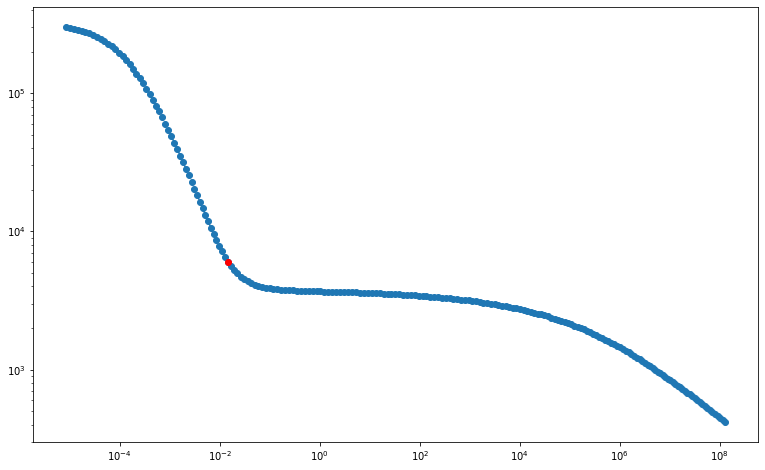

In [23]:
plt.loglog(*fsvals.T, 'o--')
idx=50
print(prange[idx])
plt.loglog(*fsvals[idx], 'ro')

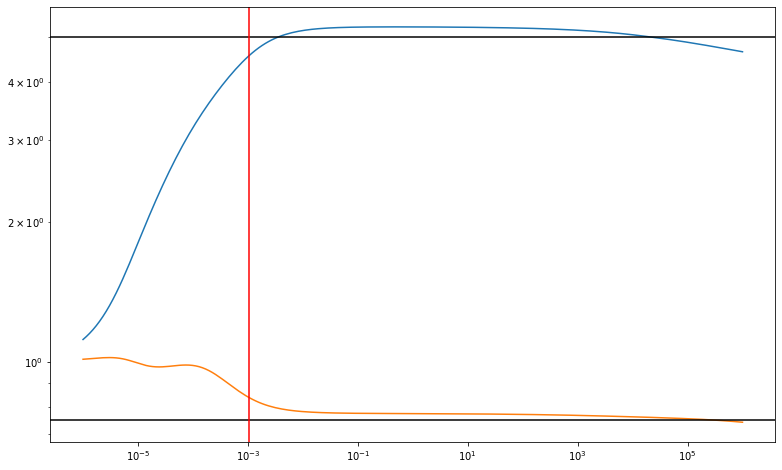

In [24]:
plt.loglog(prange, [float(getp(s['x'])[0]) for s in solutions])
plt.loglog(prange, [float(getp(s['x'])[1]) for s in solutions])
for p in p_true:
    plt.axhline(p, color='k')
idx = 50
plt.axvline(prange[idx], color='r')

[4.5509380392767085, 0.839024720543697]


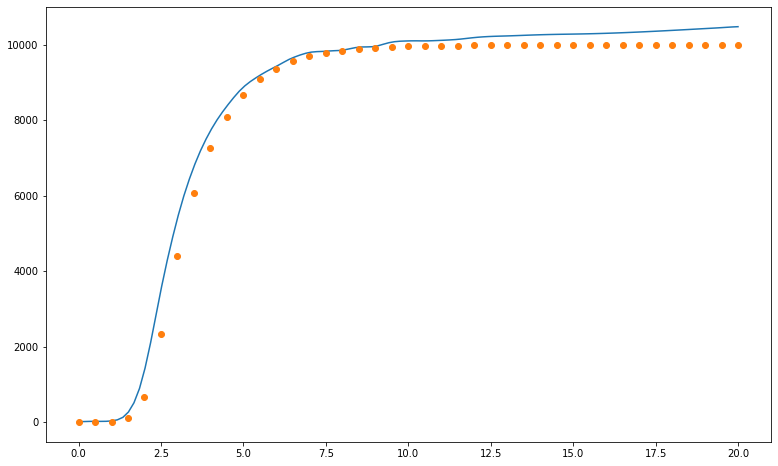

In [25]:
idx = 50
print([float(p) for p in getp(solutions[idx]['x'])])
plt.plot(model.observation_times, getx(solutions[idx]['x'])[-1], label='model')
plt.plot(tofsol, raw_data, 'o', label='data')

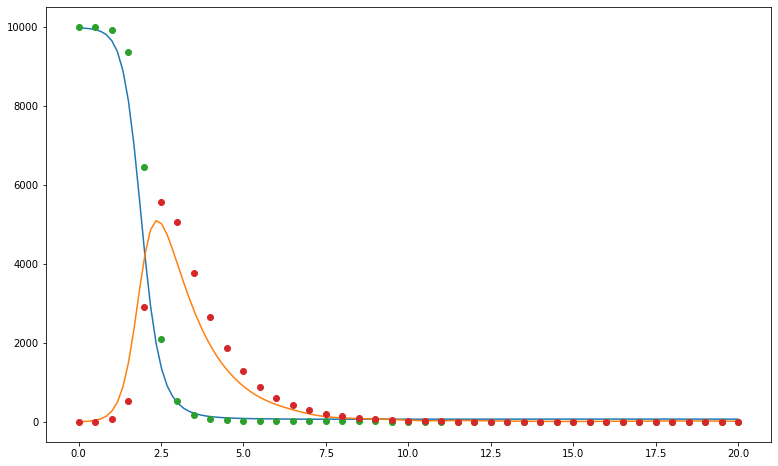

In [26]:
plt.plot(model.observation_times, getx(solutions[idx]['x'])[0], label='model, S')
plt.plot(model.observation_times, getx(solutions[idx]['x'])[1], label='model, I')
plt.plot(tofsol, sol.sol(tofsol)[:2,:].T, 'o', label='data')

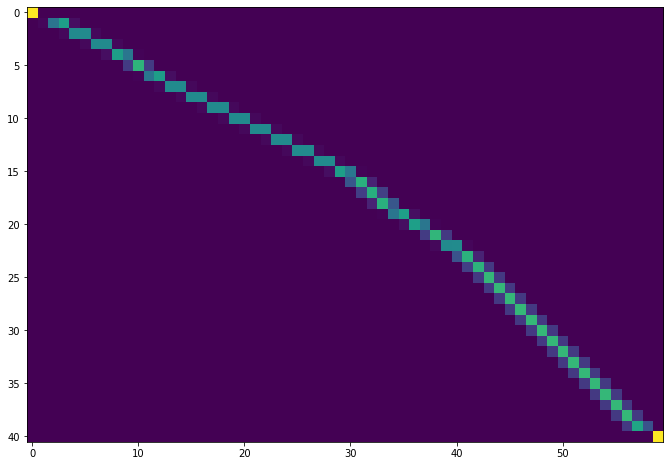

In [27]:
plt.imshow(objective.collocation_matrices[0])

[9961.742189727609, 12.339367191268874, 12.672964557658991]
[4.5509380392767085, 0.839024720543697]


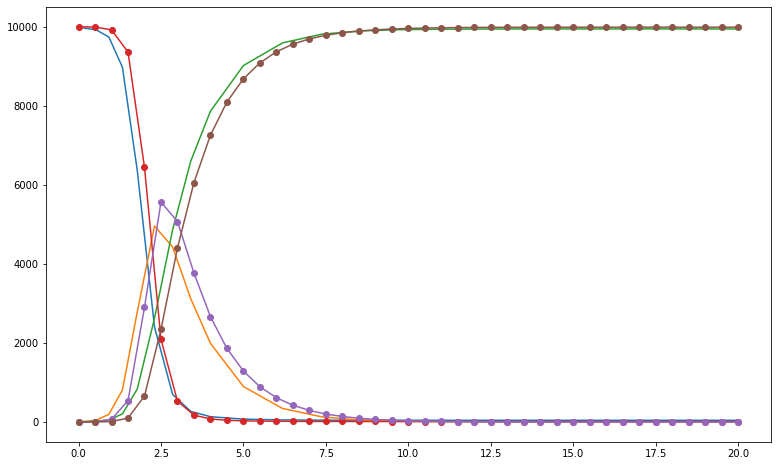

In [28]:
idx = 50
fidx = 1
xs_recovered = getx(solutions[idx]['x'])
print([float(x[fidx]) for x in xs_recovered])
p_recovered = [float(p) for p in getp(solutions[idx]['x'])]
print(p_recovered)
t0t1 = [model.observation_times[fidx], tspan[1]]
sol_recovered = solve_ivp(lambda t, y: system(t, y, p_recovered), t0t1, [x[fidx] for x in getx(solutions[idx]['x'])])
plt.plot(sol_recovered.t, sol_recovered.y.T)
plt.plot(tofsol, sol.sol(tofsol).T, 'o-')

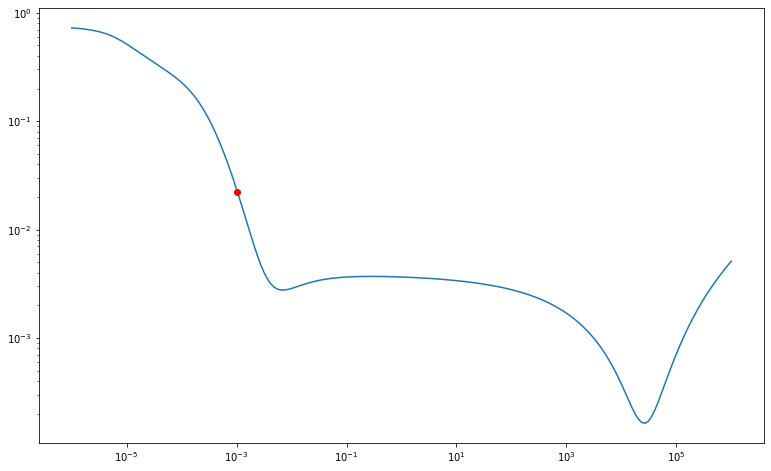

In [29]:
err = lambda i: np.sum([((a-b)/b)**2 for a, b in zip([float(p) for p in getp(solutions[i]['x'])], p_true)])
errs = [err(i) for i in range(200)]
plt.loglog(prange, errs)
idx = 50
plt.loglog(prange[idx], errs[idx], 'ro')

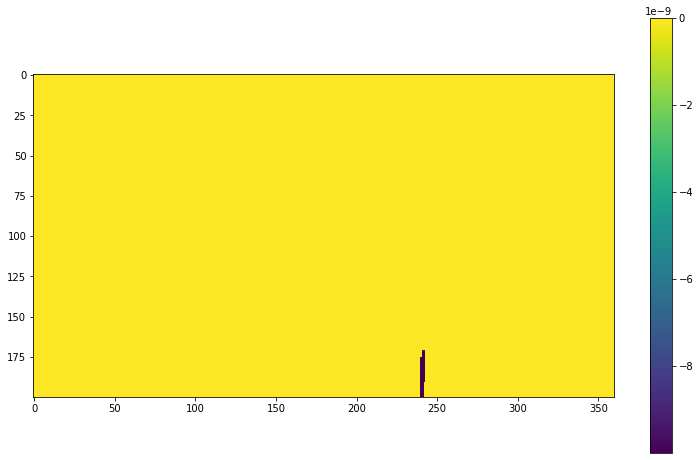

In [30]:
err2 = lambda i: [min(0, xi) for xi in np.concatenate(getx(solutions[i]['x'])).flatten()]
errs2 = np.array([err2(i) for i in range(200)])
plt.imshow(errs2)
plt.colorbar()

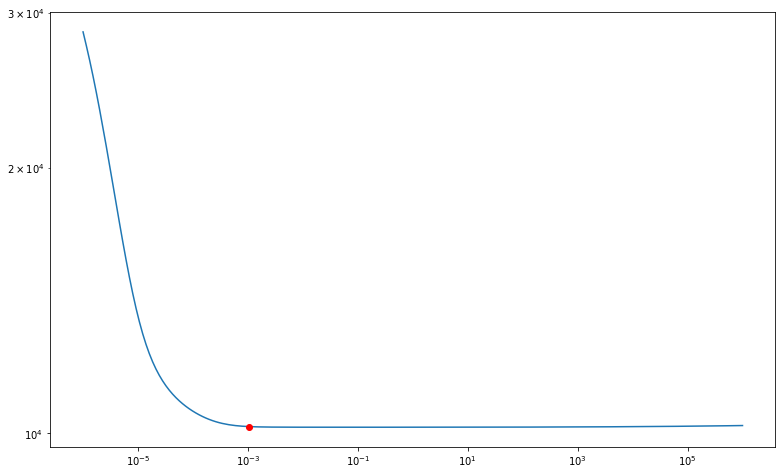

In [31]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(solutions[idx]['x'])]).sum(axis=1))
gotNs = [getN(i) for i,_ in enumerate(prange)]
plt.loglog(prange, gotNs)
idx = 50
plt.loglog(prange[idx], gotNs[idx], 'ro')

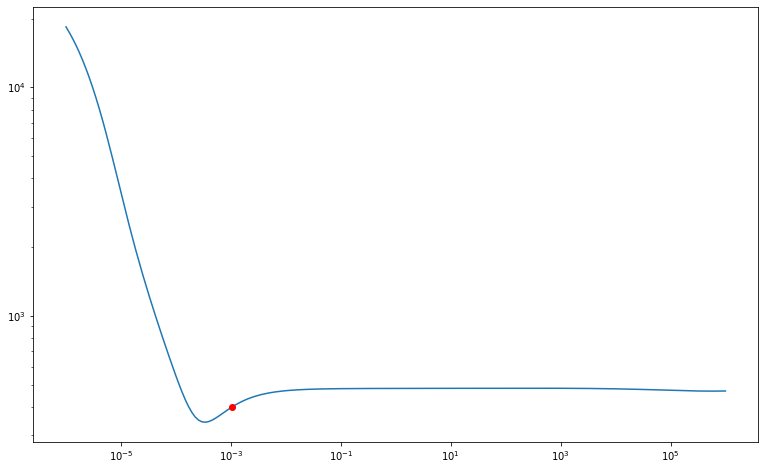

In [32]:
cvfn = lambda idx : np.sqrt(np.sum(((np.array(getx(solutions[idx]['x'])[0]).flatten()) - sol.sol(model.observation_times)[0])**2)/len(model.observation_times))
cerr = [cvfn(i) for i, _ in enumerate(prange)]
plt.loglog(prange, cerr)
idx = 50
plt.loglog(prange[idx], cerr[idx], 'ro')


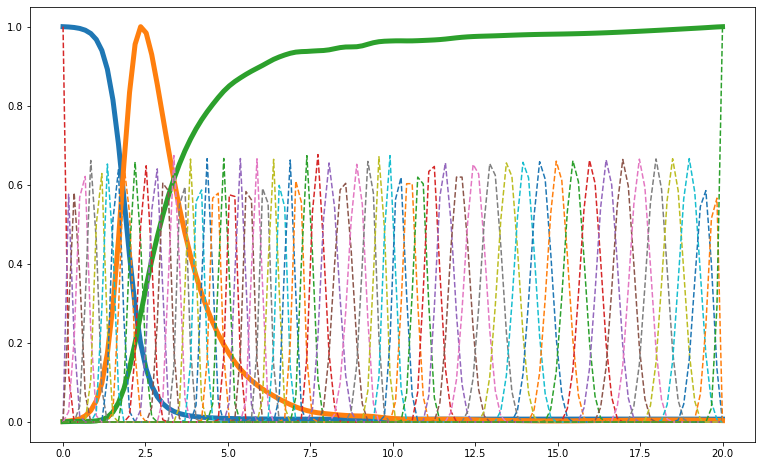

In [33]:
idx = 50
for x in getx(solutions[idx]['x']):
    xx = np.array(x).flatten()
    plt.plot(model.observation_times, xx/np.max(np.abs(xx)), linewidth=5)
plt.plot(model.observation_times, model.phi, '--');
